# 🎓 Proyecto Integrador — Maestría en Inteligencia Artificial Aplicada

## Análisis Exploratorio de Datos (EDA) — Plataforma PACS/RIS

---

**Primer Avance:** Análisis Exploratorio de Datos sobre el uso de una plataforma de imagenología médica y su relación con los ingresos.

> *Objetivo: describir los datos con técnicas estadísticas y de visualización (análisis univariante y bi/multivariante), identificar tendencias y relaciones relevantes, y aplicar operaciones de preprocesamiento justificadas.*

## Contenido

1. [Contexto del Negocio](#ctx)
2. [Configuración del Entorno y Carga de Datos](#carga)
3. [Exploración Inicial de los Datasets](#explora)
4. [Análisis de Valores Faltantes](#faltantes)
5. [Estadísticas Descriptivas](#stats)
6. [Análisis de Valores Atípicos (Outliers)](#outliers)
7. [Cardinalidad de Variables Categóricas](#cardinalidad)
8. [Análisis de Distribuciones y Sesgo](#sesgo)
9. [Tendencias Temporales](#temporal)
10. [Consolidación del Dataset Maestro](#consolidar)
11. [Análisis de Correlación](#correlacion)
12. [Análisis Bivariado y Multivariado](#bivariado)
13. [Desequilibrio en la Variable Objetivo](#desequilibrio)
14. [Preprocesamiento Aplicado y Justificado](#preprocesamiento)
15. [Conclusiones del EDA](#conclusiones)

<a name="ctx"></a>
## 1. Contexto del Negocio

El dataset proviene de una **plataforma SaaS de imagenología médica** que ofrece un sistema PACS (*Picture Archiving and Communication System*) y RIS (*Radiology Information System*) a clínicas, hospitales y laboratorios en **Latinoamérica**.

### 1.1 Variable Objetivo (Dependiente)
- **Ingresos por organización:** Revenue (USD) generado por cada cliente en un periodo mensual.

### 1.2 Datos del Producto
| Fuente | Descripción |
|--------|-------------|
| Estudios por org. y sucursal | Total de estudios con desglose por sucursal |
| Estudios por org. y modalidad | Segmentados por tipo de equipo (CT, US, CR, MR, etc.) |
| Estudios con AI Tórax | Uso de la funcionalidad de AI Tórax |
| Estudios con AI Report | Uso de la funcionalidad de AI Report |
| Usuarios dentro del PACS | Médicos que firmaron al menos un estudio |
| Envío de estudios | Estudios enviados por email y WhatsApp |
| Fecha de inicio de facturación | Inicio de facturación por cliente |
| Estudios (PACS) firmados y reportados | Adopción efectiva del producto |
| Estudios (RIS) por órdenes | Uso del módulo RIS |

### 1.3 Datos del CRM
| Fuente | Descripción |
|--------|-------------|
| Estudios potenciales (contrato) | Capacidad máxima teórica del cliente |
| Fecha de instalación | Instalación de hardware y conexión de modalidades |

> **Los datos del CRM se estandarizaron a partir de 2025, por lo que presentan mayor inconsistencia que los datos del producto.**

<a name="carga"></a>
## 2. Configuración del Entorno y Carga de Datos

### 2.1 Importaciones

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from scipy import stats as sp_stats
from scipy.stats import skew, kurtosis
import warnings, os

warnings.filterwarnings('ignore')
plt.rcParams.update({'figure.figsize': (12, 6), 'font.size': 11,
                     'axes.titlesize': 14, 'axes.labelsize': 12})
sns.set_theme(style='whitegrid', palette='muted')
print('Librerías cargadas')

Librerías cargadas


### 2.2 Montar Google Drive y definir ruta de datos

In [4]:
from google.colab import drive
drive.mount('/content/drive')

DATA_DIR = '/content/drive/MyDrive/proyecto integrador (grupo 4)/datos_v1'

archivos = sorted([f for f in os.listdir(DATA_DIR) if f.endswith('.xlsx')])
print(f'{len(archivos)} archivos encontrados:')
for f in archivos:
    print(f'   • {f}  ({os.path.getsize(os.path.join(DATA_DIR, f))/1024:.0f} KB)')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
13 archivos encontrados:
   • Envío de estudios por organización.xlsx  (600 KB)
   • Estudios (PACS) firmados y reportados por organización.xlsx  (1165 KB)
   • Estudios (RIS) realizados por ordenes y por organización.xlsx  (27 KB)
   • Estudios firmados y reportados por organización.xlsx  (5 KB)
   • Estudios por organización de AI Report.xlsx  (11 KB)
   • Estudios por organización de AI Tórax.xlsx  (10 KB)
   • Estudios por organización y modalidad.xlsx  (2442 KB)
   • Estudios por organización y sucursal.xlsx  (1411 KB)
   • Fecha de Instalación por organización.xlsx  (16 KB)
   • Fecha de inicio de facturación por organización.xlsx  (36 KB)
   • Ingresos por Organización.xlsx  (731 KB)
   • Número de estudios potenciales (establecido en contrato) por organización.xlsx  (52 KB)
   • Número de usuarios dentro del PACS.xlsx  (403 KB)


### 2.3 Funciones auxiliares

In [5]:
def cargar_multi_hojas(filepath):
    """Consolida hojas (una por año) de un Excel en un solo DataFrame."""
    xlsx = pd.ExcelFile(filepath)
    frames = []
    for sheet in xlsx.sheet_names:
        df = pd.read_excel(filepath, sheet_name=sheet)
        if 'year' not in df.columns:
            df['year'] = sheet
        frames.append(df)
    return pd.concat(frames, ignore_index=True)


def buscar(keyword):
    """Busca un archivo por palabra clave."""
    for f in archivos:
        if keyword.lower() in f.lower():
            return os.path.join(DATA_DIR, f)
    raise FileNotFoundError(f'No se encontró archivo con keyword: {keyword}')

### 2.4 Carga de todos los datasets

In [6]:
# ── Variable Objetivo ──────────────────────────────────
df_ingresos = pd.read_excel(buscar('Ingresos'))
COL_ING = 'Ingresos USD (Tasa 1 USD =19.3 MXN)'  # alias para la columna de ingresos

# ── Datos del Producto ────────────────────────────────
df_sucursal  = cargar_multi_hojas(buscar('sucursal'))
df_modalidad = cargar_multi_hojas(buscar('modalidad'))
df_ai_torax  = pd.read_excel(buscar('rax'))
df_ai_report = pd.read_excel(buscar('AI Rep'))
df_usuarios  = cargar_multi_hojas(buscar('usuarios'))
df_envio     = cargar_multi_hojas(buscar('Env'))
df_facturacion = pd.read_excel(buscar('facturaci'))
df_pacs = pd.read_excel(buscar('(PACS)'))
df_ris       = pd.read_excel(buscar('RIS'))

# ── Datos del CRM ────────────────────────────────────
df_potencial   = pd.read_excel(buscar('potencial'))
df_instalacion = pd.read_excel(buscar('nstalaci'))

# ── Resumen de lo cargado ──
datasets = {
    'Ingresos (target)': df_ingresos,  'Estudios x Sucursal': df_sucursal,
    'Estudios x Modalidad': df_modalidad, 'AI Tórax': df_ai_torax,
    'AI Report': df_ai_report, 'Usuarios PACS': df_usuarios,
    'Envío Estudios': df_envio, 'Fecha Facturación': df_facturacion,
    'PACS Firmados': df_pacs, 'RIS Órdenes': df_ris,
    'Potencial (CRM)': df_potencial, 'Fecha Instalación': df_instalacion,
}

print(f'\n{"Dataset":<30} {"Filas":>10} {"Columnas":>10}')
print('─' * 52)
for nombre, df in datasets.items():
    print(f'{nombre:<30} {df.shape[0]:>10,} {df.shape[1]:>10}')
print(f'\n {len(datasets)} datasets cargados exitosamente')


Dataset                             Filas   Columnas
────────────────────────────────────────────────────
Ingresos (target)                  29,226          5
Estudios x Sucursal                68,172          5
Estudios x Modalidad              130,063          5
AI Tórax                              141          7
AI Report                              87          7
Usuarios PACS                      25,361          4
Envío Estudios                     27,673          5
Fecha Facturación                   1,346          2
PACS Firmados                      29,298         10
RIS Órdenes                           354          7
Potencial (CRM)                     1,557          4
Fecha Instalación                     434          2

 12 datasets cargados exitosamente


<a name="explora"></a>
## 3. 🔍 Exploración Inicial de los Datasets

### 3.1 Variable Objetivo — Ingresos

In [7]:
display(df_ingresos.head(8))
print()
df_ingresos.info()
print(f'\n Organizaciones únicas   : {df_ingresos["name"].nunique():,}')
print(f' Rango temporal          : {df_ingresos["ingresos_month"].min()} → {df_ingresos["ingresos_month"].max()}')
print(f' Tipos de producto       : {df_ingresos["product_type"].unique().tolist()}')
print(f' Registros con ingreso=0 : {(df_ingresos[COL_ING]==0).sum()}')

,name,invoice_start_date,product_type,Ingresos USD (Tasa 1 USD =19.3 MXN),ingresos_month
0,ADNLAB,2023-08-24,PACS_FIXED_FEE,148,2024-01-01
1,ADNLAB,2023-08-24,PACS_FIXED_FEE,162,2024-09-01
2,ADNLAB,2023-08-24,PACS_HIGH_LOW_STUDIES,45,2024-05-01
3,ADNLAB,2023-08-24,PACS_HIGH_LOW_STUDIES,29,2024-02-01
4,ADNLAB,2023-08-24,PACS_NO_DICOM_STUDY,1,2024-02-01
5,ADNLAB,2023-08-24,PACS_FIXED_FEE,148,2024-07-01
6,ADNLAB,2023-08-24,PACS_FIXED_FEE,148,2024-03-01
7,ADNLAB,2023-08-24,PACS_FIXED_FEE,148,2024-04-01



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29226 entries, 0 to 29225
Data columns (total 5 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   name                                 29226 non-null  object        
 1   invoice_start_date                   29226 non-null  datetime64[ns]
 2   product_type                         29226 non-null  object        
 3   Ingresos USD (Tasa 1 USD =19.3 MXN)  29226 non-null  int64         
 4   ingresos_month                       29226 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(2)
memory usage: 1.1+ MB

 Organizaciones únicas   : 1,476
 Rango temporal          : 2024-01-01 00:00:00 → 2026-01-01 00:00:00
 Tipos de producto       : ['PACS_FIXED_FEE', 'PACS_HIGH_LOW_STUDIES', 'PACS_NO_DICOM_STUDY', 'PACS_STUDY_LOW_PRICE', 'PACS_HIGH_PRICE']
 Registros con ingreso=0 : 81


### 3.2 Vista rápida — Datos del Producto y CRM

In [8]:
print('─' * 75)
print(f'{"Dataset":<35} {"Filas":>10} {"Columnas":>6} {"Orgs Únicas":>12}')
print('─' * 75)

org_cols = {
    'Estudios x Sucursal': ('organization', df_sucursal),
    'Estudios x Modalidad': ('organization', df_modalidad),
    'Usuarios PACS': ('organization_name', df_usuarios),
    'Envío Estudios': ('organization_name', df_envio),
    'PACS Firmados': ('organization', df_pacs),
    'RIS Órdenes': ('name', df_ris),
    'AI Tórax': (df_ai_torax.columns[0], df_ai_torax),
    'AI Report': ('organization', df_ai_report),
    'Potencial (CRM)': ('Cuenta', df_potencial),
    'Fecha Instalación': (df_instalacion.columns[1], df_instalacion),
    'Fecha Facturación': ('name', df_facturacion),
}

for nombre, (col, df) in org_cols.items():
    print(f'{nombre:<35} {df.shape[0]:>10,} {df.shape[1]:>6} {df[col].nunique():>12,}')
print('─' * 75)

───────────────────────────────────────────────────────────────────────────
Dataset                                  Filas Columnas  Orgs Únicas
───────────────────────────────────────────────────────────────────────────
Estudios x Sucursal                     68,172      5        1,604
Estudios x Modalidad                   130,063      5        1,604
Usuarios PACS                           25,361      4        1,430
Envío Estudios                          27,673      5        1,507
PACS Firmados                           29,298     10        1,605
RIS Órdenes                                354      7          354
AI Tórax                                   141      7           50
AI Report                                   87      7           32
Potencial (CRM)                          1,557      4        1,557
Fecha Instalación                          434      2          426
Fecha Facturación                        1,346      2        1,346
──────────────────────────────────────────

<a name="faltantes"></a>
## 4. Análisis de Valores Faltantes

> **Pregunta EDA:** *¿Hay valores faltantes? ¿Se pueden identificar patrones de ausencia?*

In [9]:
# Tabla resumen de faltantes por dataset
resumen = []
for nombre, df in datasets.items():
    total = df.size
    falt = df.isnull().sum().sum()
    resumen.append({'Dataset': nombre, 'Filas': df.shape[0],
                    'Cols': df.shape[1],
                    'Cols_con_NaN': (df.isnull().sum() > 0).sum(),
                    'Celdas_NaN': falt,
                    '%_NaN': round(falt / total * 100, 2) if total else 0})

df_miss = pd.DataFrame(resumen).sort_values('%_NaN', ascending=False)
display(df_miss.style.background_gradient(subset=['%_NaN'], cmap='YlOrRd'))

,Dataset,Filas,Cols,Cols_con_NaN,Celdas_NaN,%_NaN
10,Potencial (CRM),1557,4,3,985,15.820000
4,AI Report,87,7,2,64,10.510000
11,Fecha Instalación,434,2,1,2,0.230000
0,Ingresos (target),29226,5,0,0,0.000000
3,AI Tórax,141,7,0,0,0.000000
2,Estudios x Modalidad,130063,5,1,2,0.000000
1,Estudios x Sucursal,68172,5,0,0,0.000000
5,Usuarios PACS,25361,4,0,0,0.000000
7,Fecha Facturación,1346,2,0,0,0.000000
6,Envío Estudios,27673,5,0,0,0.000000


In [10]:
# Detalle de columnas con faltantes
for nombre, df in datasets.items():
    m = df.isnull().sum()
    m = m[m > 0]
    if len(m) > 0:
        print(f'\n {nombre}')
        for col, n in m.items():
            print(f'   {col:<50} {n:>6} ({n/len(df)*100:.1f}%)')


 Estudios x Modalidad
   modalities                                              2 (0.0%)

 AI Report
   year                                                   32 (36.8%)
   month.1                                                32 (36.8%)

 Potencial (CRM)
   Potencial Mes (contrato)                               74 (4.8%)
   País                                                   82 (5.3%)
   Closed Won Date (HS)                                  829 (53.2%)

 Fecha Instalación
   Fecha de instalación (from Cierres de instalación)      2 (0.5%)


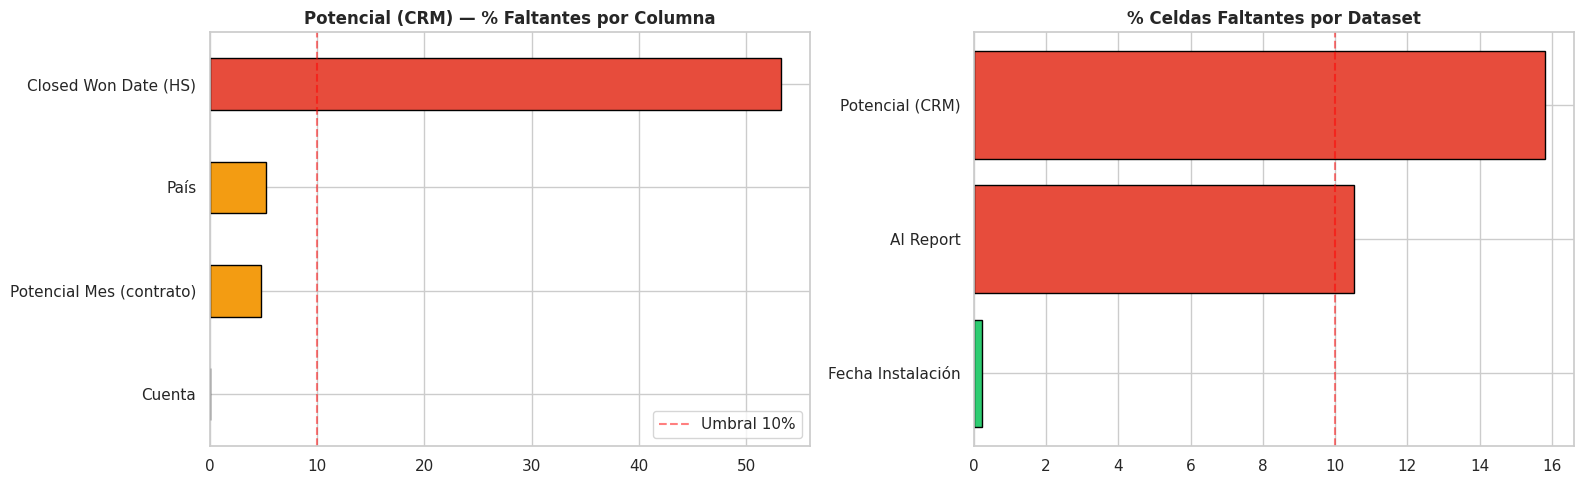

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# 1. Potencial (CRM) — columnas
ax = axes[0]
miss_pct = (df_potencial.isnull().sum() / len(df_potencial) * 100).sort_values()
colors = ['#e74c3c' if v > 10 else '#f39c12' if v > 1 else '#2ecc71' for v in miss_pct]
miss_pct.plot.barh(ax=ax, color=colors, edgecolor='black')
ax.set_title('Potencial (CRM) — % Faltantes por Columna', fontweight='bold')
ax.axvline(x=10, color='red', ls='--', alpha=.5, label='Umbral 10%')
ax.legend()

# 2. Resumen por dataset
ax = axes[1]
df_plot = df_miss[df_miss['%_NaN'] > 0].sort_values('%_NaN')
cols = ['#e74c3c' if v > 10 else '#f39c12' if v > 1 else '#2ecc71' for v in df_plot['%_NaN']]
ax.barh(df_plot['Dataset'], df_plot['%_NaN'], color=cols, edgecolor='black')
ax.set_title('% Celdas Faltantes por Dataset', fontweight='bold')
ax.axvline(x=10, color='red', ls='--', alpha=.5)

plt.tight_layout()
plt.show()

### 4.1 Interpretación de los patrones de ausencia

| Patrón | Datasets | Tipo | Justificación |
|--------|----------|------|---------------|
| CRM pre-2025 | Potencial — `Closed Won Date` 53% | **MAR** | Estandarización tardía del CRM |
| Columnas vacías | AI Report — `Unnamed` 37% | **Estructural** | Metadata de Excel sin datos |
| Registros aislados | Fecha Inst. (0.2%), Modalidad (<0.01%) | **MCAR** | Errores puntuales |
| Sin faltantes | Ingresos, Sucursal, PACS, Usuarios, Envío, RIS | — | Datos generados automáticamente |

<a name="stats"></a>
## 5. 📊 Estadísticas Descriptivas

> **Pregunta EDA:** *¿Cuáles son las estadísticas resumidas del conjunto de datos?*

In [12]:
data = df_ingresos[COL_ING]

info = {
    'Conteo': f'{data.count():,}',
    'Media': f'${data.mean():,.2f}',
    'Mediana': f'${data.median():,.2f}',
    'Desv. Estándar': f'${data.std():,.2f}',
    'Mínimo': f'${data.min():,.2f}',
    'P25': f'${data.quantile(.25):,.2f}',
    'P75': f'${data.quantile(.75):,.2f}',
    'P95': f'${data.quantile(.95):,.2f}',
    'P99': f'${data.quantile(.99):,.2f}',
    'Máximo': f'${data.max():,.2f}',
    'Coef. Variación': f'{data.std()/data.mean()*100:.1f}%',
    'Sesgo': f'{skew(data):.2f}',
    'Curtosis': f'{kurtosis(data):.2f}',
}

print(' ESTADÍSTICAS DE INGRESOS USD')
print('─' * 45)
for k, v in info.items():
    print(f'  {k:<22} {v:>18}')

 ESTADÍSTICAS DE INGRESOS USD
─────────────────────────────────────────────
  Conteo                             29,226
  Media                             $398.64
  Mediana                           $106.00
  Desv. Estándar                  $2,020.51
  Mínimo                              $0.00
  P25                                $25.00
  P75                               $306.00
  P95                             $1,277.75
  P99                             $4,197.00
  Máximo                         $86,817.00
  Coef. Variación                    506.9%
  Sesgo                               24.60
  Curtosis                           752.77


In [13]:
# Estadísticas por tipo de producto
stats_prod = df_ingresos.groupby('product_type')[COL_ING].agg(
    ['count', 'mean', 'median', 'std', 'max']).round(2)
stats_prod.columns = ['N', 'Media', 'Mediana', 'Std', 'Máx']
display(stats_prod.sort_values('N', ascending=False)
        .style.format({'N':'{:,.0f}','Media':'${:,.2f}','Mediana':'${:,.2f}','Std':'${:,.2f}','Máx':'${:,.2f}'})
        .background_gradient(subset=['Media'], cmap='Greens'))

,N,Media,Mediana,Std,Máx
product_type,,,,,
PACS_HIGH_LOW_STUDIES,"18,905",$379.44,$101.00,"$2,389.84","$86,817.00"
PACS_FIXED_FEE,"5,526",$676.19,$306.00,"$1,202.69","$19,206.00"
PACS_NO_DICOM_STUDY,"4,017",$22.18,$3.00,$77.93,"$1,216.00"
PACS_HIGH_PRICE,396,$647.49,$162.50,"$1,167.67","$5,919.00"
PACS_STUDY_LOW_PRICE,382,"$1,034.59",$327.00,"$2,054.07","$10,671.00"


In [14]:
# Estadísticas de variables independientes clave
vars_indep = [
    ('Estudios x Sucursal', df_sucursal['study_count']),
    ('Usuarios PACS', df_usuarios['active_doctors_count']),
    ('Envíos Email', df_envio['studies_sent_via_email']),
    ('Envíos SMS', df_envio['studies_sent_via_sms']),
    ('Total PACS', df_pacs['total']),
    ('Firmados PACS', df_pacs['signed']),
    ('Potencial (contrato)', df_potencial['Potencial Mes (contrato)'].dropna()),
]

rows = []
for nombre, serie in vars_indep:
    rows.append({'Variable': nombre, 'N': len(serie),
                 'Media': serie.mean(), 'Mediana': serie.median(),
                 'Std': serie.std(), 'Min': serie.min(), 'Max': serie.max()})

display(pd.DataFrame(rows).style.format(
    {'N':'{:,.0f}','Media':'{:,.2f}','Mediana':'{:,.2f}','Std':'{:,.2f}','Min':'{:,.0f}','Max':'{:,.0f}'}
))

,Variable,N,Media,Mediana,Std,Min,Max
0,Estudios x Sucursal,"68,172",308.77,132.00,557.94,1,"24,223"
1,Usuarios PACS,"25,361",4.20,2.00,20.88,1,684
2,Envíos Email,"27,673",99.50,8.00,358.62,0,"14,167"
3,Envíos SMS,"27,673",252.55,78.00,621.44,0,"13,284"
4,Total PACS,"29,298",641.88,143.00,"4,239.03",1,"168,901"
5,Firmados PACS,"29,298",299.33,10.00,"3,867.81",0,"148,629"
6,Potencial (contrato),"1,483",184.90,100.00,215.84,0,950


<a name="outliers"></a>
## 6. Análisis de Valores Atípicos

> **Pregunta EDA:** *¿Hay valores atípicos en el conjunto de datos?*

In [15]:
def iqr_outliers(serie, nombre):
    Q1, Q3 = serie.quantile(.25), serie.quantile(.75)
    IQR = Q3 - Q1
    upper = Q3 + 1.5 * IQR
    n_out = (serie > upper).sum()
    return {'Variable': nombre, 'Q1': Q1, 'Q3': Q3, 'IQR': IQR,
            'Límite_Sup': upper, 'N_Outliers': n_out,
            '%_Outliers': round(n_out / len(serie) * 100, 2)}

out_results = [iqr_outliers(s, n) for n, s in vars_indep + [('Ingresos USD', df_ingresos[COL_ING])]]
df_out = pd.DataFrame(out_results).sort_values('%_Outliers', ascending=False)
display(df_out.style.format({'Q1':'{:,.1f}','Q3':'{:,.1f}','IQR':'{:,.1f}',
    'Límite_Sup':'{:,.1f}','N_Outliers':'{:,}','%_Outliers':'{:.1f}%'})
    .background_gradient(subset=['%_Outliers'], cmap='Reds'))

,Variable,Q1,Q3,IQR,Límite_Sup,N_Outliers,%_Outliers
5,Firmados PACS,0.0,82.0,82.0,205.0,"4,172",14.2%
2,Envíos Email,1.0,62.0,61.0,153.5,"3,869",14.0%
3,Envíos SMS,23.0,223.0,200.0,523.0,"3,229",11.7%
7,Ingresos USD,25.0,306.0,281.0,727.5,"3,185",10.9%
4,Total PACS,46.0,418.0,372.0,976.0,"2,935",10.0%
0,Estudios x Sucursal,41.0,339.0,298.0,786.0,"6,708",9.8%
1,Usuarios PACS,1.0,4.0,3.0,8.5,"1,415",5.6%
6,Potencial (contrato),16.0,290.5,274.5,702.2,49,3.3%


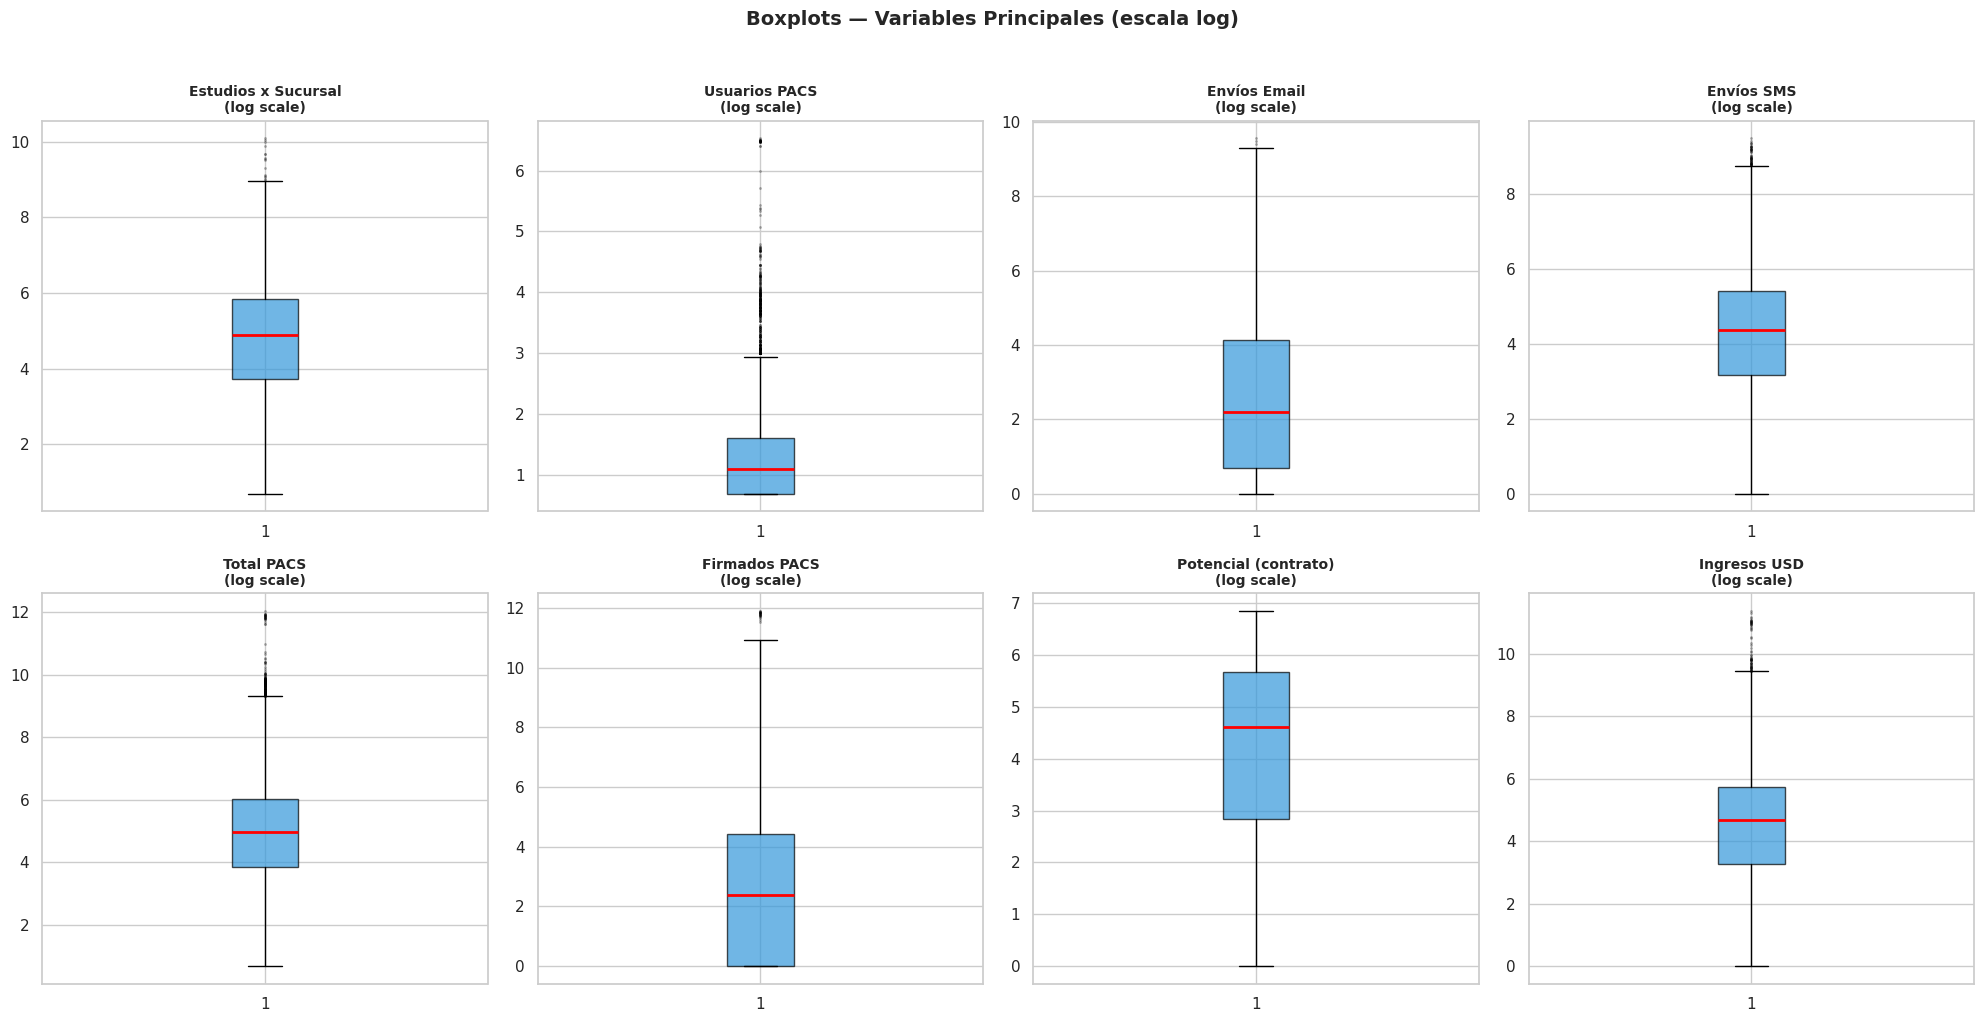

In [16]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
all_vars = vars_indep + [('Ingresos USD', df_ingresos[COL_ING])]

for idx, (nombre, serie) in enumerate(all_vars):
    ax = axes[idx // 4, idx % 4]
    bp = ax.boxplot(np.log1p(serie.dropna()), vert=True, patch_artist=True,
                    boxprops=dict(facecolor='#3498db', alpha=.7),
                    medianprops=dict(color='red', linewidth=2),
                    flierprops=dict(marker='.', markersize=2, alpha=.3))
    ax.set_title(f'{nombre}\n(log scale)', fontweight='bold', fontsize=10)

plt.suptitle('Boxplots — Variables Principales (escala log)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [17]:
# Outlier principal: PROA
top15 = df_ingresos.nlargest(15, COL_ING)[['name', COL_ING, 'product_type', 'ingresos_month']]
display(top15)

proa_total = df_ingresos[df_ingresos['name']=='PROA'][COL_ING].sum()
total = df_ingresos[COL_ING].sum()
print(f'\n PROA genera ${proa_total:,.0f} = {proa_total/total*100:.1f}% del ingreso total')

,name,Ingresos USD (Tasa 1 USD =19.3 MXN),product_type,ingresos_month
8260,PROA,86817,PACS_HIGH_LOW_STUDIES,2024-05-01
8258,PROA,81015,PACS_HIGH_LOW_STUDIES,2024-04-01
24762,PROA,70653,PACS_HIGH_LOW_STUDIES,2025-08-01
8266,PROA,69618,PACS_HIGH_LOW_STUDIES,2024-03-01
8253,PROA,64983,PACS_HIGH_LOW_STUDIES,2024-10-01
24746,PROA,64339,PACS_HIGH_LOW_STUDIES,2025-10-01
24744,PROA,63341,PACS_HIGH_LOW_STUDIES,2025-07-01
17,PROA,63083,PACS_HIGH_LOW_STUDIES,2024-11-01
24763,PROA,61735,PACS_HIGH_LOW_STUDIES,2025-05-01
24749,PROA,61011,PACS_HIGH_LOW_STUDIES,2025-03-01



 PROA genera $1,463,248 = 12.6% del ingreso total


<a name="cardinalidad"></a>
## 7. Cardinalidad de Variables Categóricas

> **Pregunta EDA:** *¿Cuál es la cardinalidad de las variables categóricas?*

In [18]:
cat_vars = [
    ('Ingresos', df_ingresos, 'name'),
    ('Ingresos', df_ingresos, 'product_type'),
    ('Sucursal', df_sucursal, 'facility'),
    ('Modalidad', df_modalidad, 'modalities'),
    ('Potencial', df_potencial, 'País'),
]

rows = []
for ds, df, col in cat_vars:
    nu = df[col].nunique()
    rows.append({'Dataset': ds, 'Variable': col, 'Valores_Únicos': nu,
                 'Total_Filas': len(df), 'Ratio_%': round(nu/len(df)*100, 2),
                 'Alta_Cardinalidad': '⚠️ Sí' if nu > 100 else '✅ No'})

display(pd.DataFrame(rows))

,Dataset,Variable,Valores_Únicos,Total_Filas,Ratio_%,Alta_Cardinalidad
0,Ingresos,name,1476,29226,5.05,⚠️ Sí
1,Ingresos,product_type,5,29226,0.02,✅ No
2,Sucursal,facility,3050,68172,4.47,⚠️ Sí
3,Modalidad,modalities,550,130063,0.42,⚠️ Sí
4,Potencial,País,17,1557,1.09,✅ No


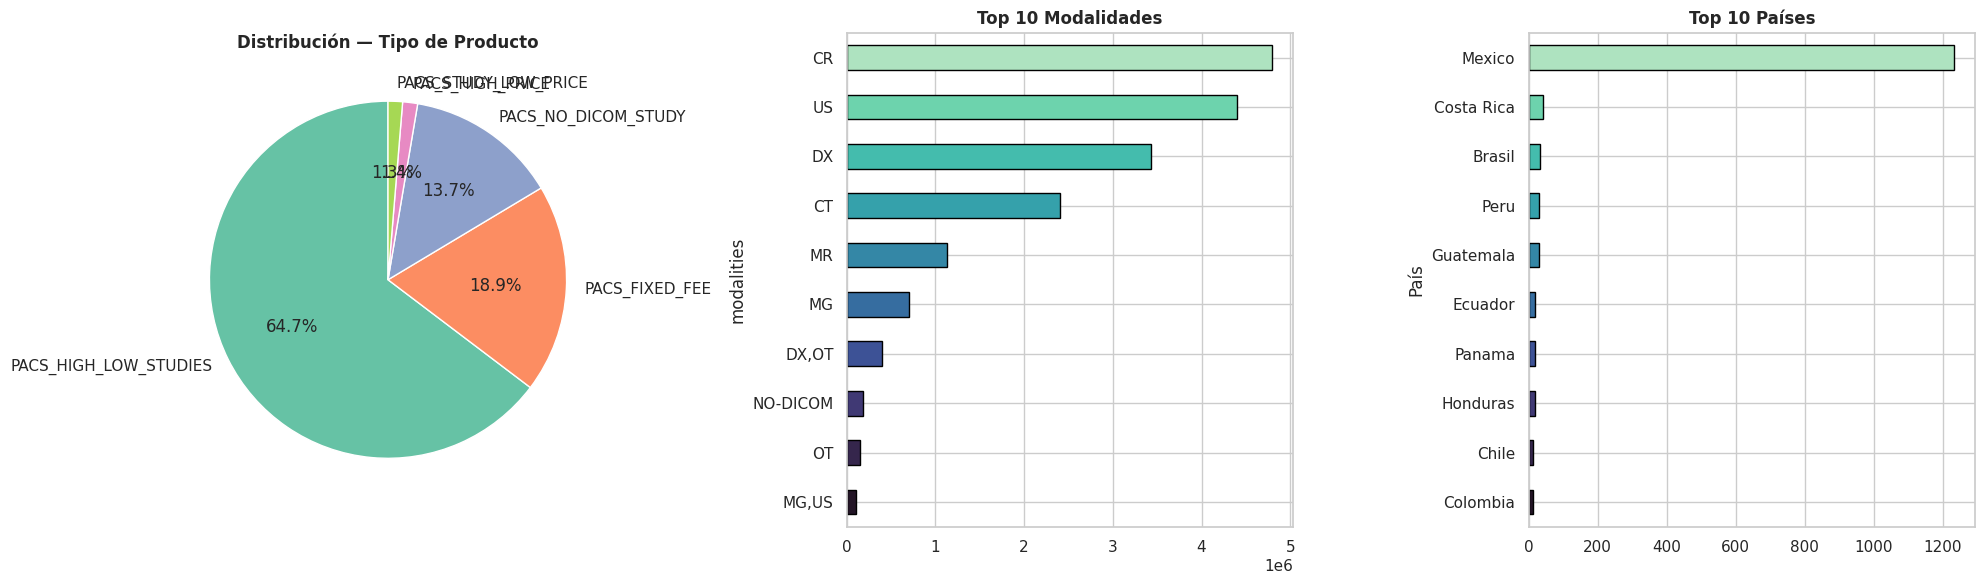

In [42]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Tipo de producto
ax = axes[0]
df_ingresos['product_type'].value_counts().plot.pie(
    ax=ax, autopct='%1.1f%%', colors=sns.color_palette('Set2', 5), startangle=90)
ax.set_title('Distribución — Tipo de Producto', fontweight='bold')
ax.set_ylabel('')

# Top modalidades
ax = axes[1]
df_modalidad.groupby('modalities')['study_count'].sum().nlargest(10).sort_values().plot.barh(
    ax=ax, color=sns.color_palette('mako', 10), edgecolor='black')
ax.set_title('Top 10 Modalidades', fontweight='bold')

# País
ax = axes[2]
df_potencial['País'].value_counts().head(10).sort_values().plot.barh(
    ax=ax, color=sns.color_palette('mako', 10), edgecolor='black')
ax.set_title('Top 10 Países', fontweight='bold')

plt.tight_layout()
plt.show()

<a name="sesgo"></a>
## 8. Análisis de Distribuciones y Sesgo

> **Pregunta EDA:** *¿Existen distribuciones sesgadas? ¿Necesitamos transformaciones no lineales?*

In [43]:
tabla = []
for nombre, serie in vars_indep + [('Ingresos USD', df_ingresos[COL_ING])]:
    s = skew(serie.dropna())
    k = kurtosis(serie.dropna())
    interp = 'Simétrica' if abs(s)<.5 else ('Moderada' if abs(s)<1 else 'Altamente sesgada')
    tabla.append({'Variable': nombre, 'Skewness': round(s,2), 'Curtosis': round(k,2),
                  'Interpretación': interp, 'Transformación': 'log(x+1)' if abs(s)>1 else 'Ninguna'})

df_sk = pd.DataFrame(tabla)

def color_interp(val):
    if val == 'Altamente sesgada':
        return 'background-color: #e74c3c; color: white; font-weight: bold'
    elif val == 'Moderada':
        return 'background-color: #f39c12; color: white; font-weight: bold'
    return ''

display(df_sk.style.applymap(color_interp, subset=['Interpretación']))

,Variable,Skewness,Curtosis,Interpretación,Transformación
0,Estudios x Sucursal,8.710000,206.160000,Altamente sesgada,log(x+1)
1,Usuarios PACS,27.980000,852.210000,Altamente sesgada,log(x+1)
2,Envíos Email,13.640000,323.570000,Altamente sesgada,log(x+1)
3,Envíos SMS,7.970000,94.230000,Altamente sesgada,log(x+1)
4,Total PACS,28.200000,917.890000,Altamente sesgada,log(x+1)
5,Firmados PACS,32.230000,1107.940000,Altamente sesgada,log(x+1)
6,Potencial (contrato),1.440000,1.330000,Altamente sesgada,log(x+1)
7,Ingresos USD,24.600000,752.770000,Altamente sesgada,log(x+1)


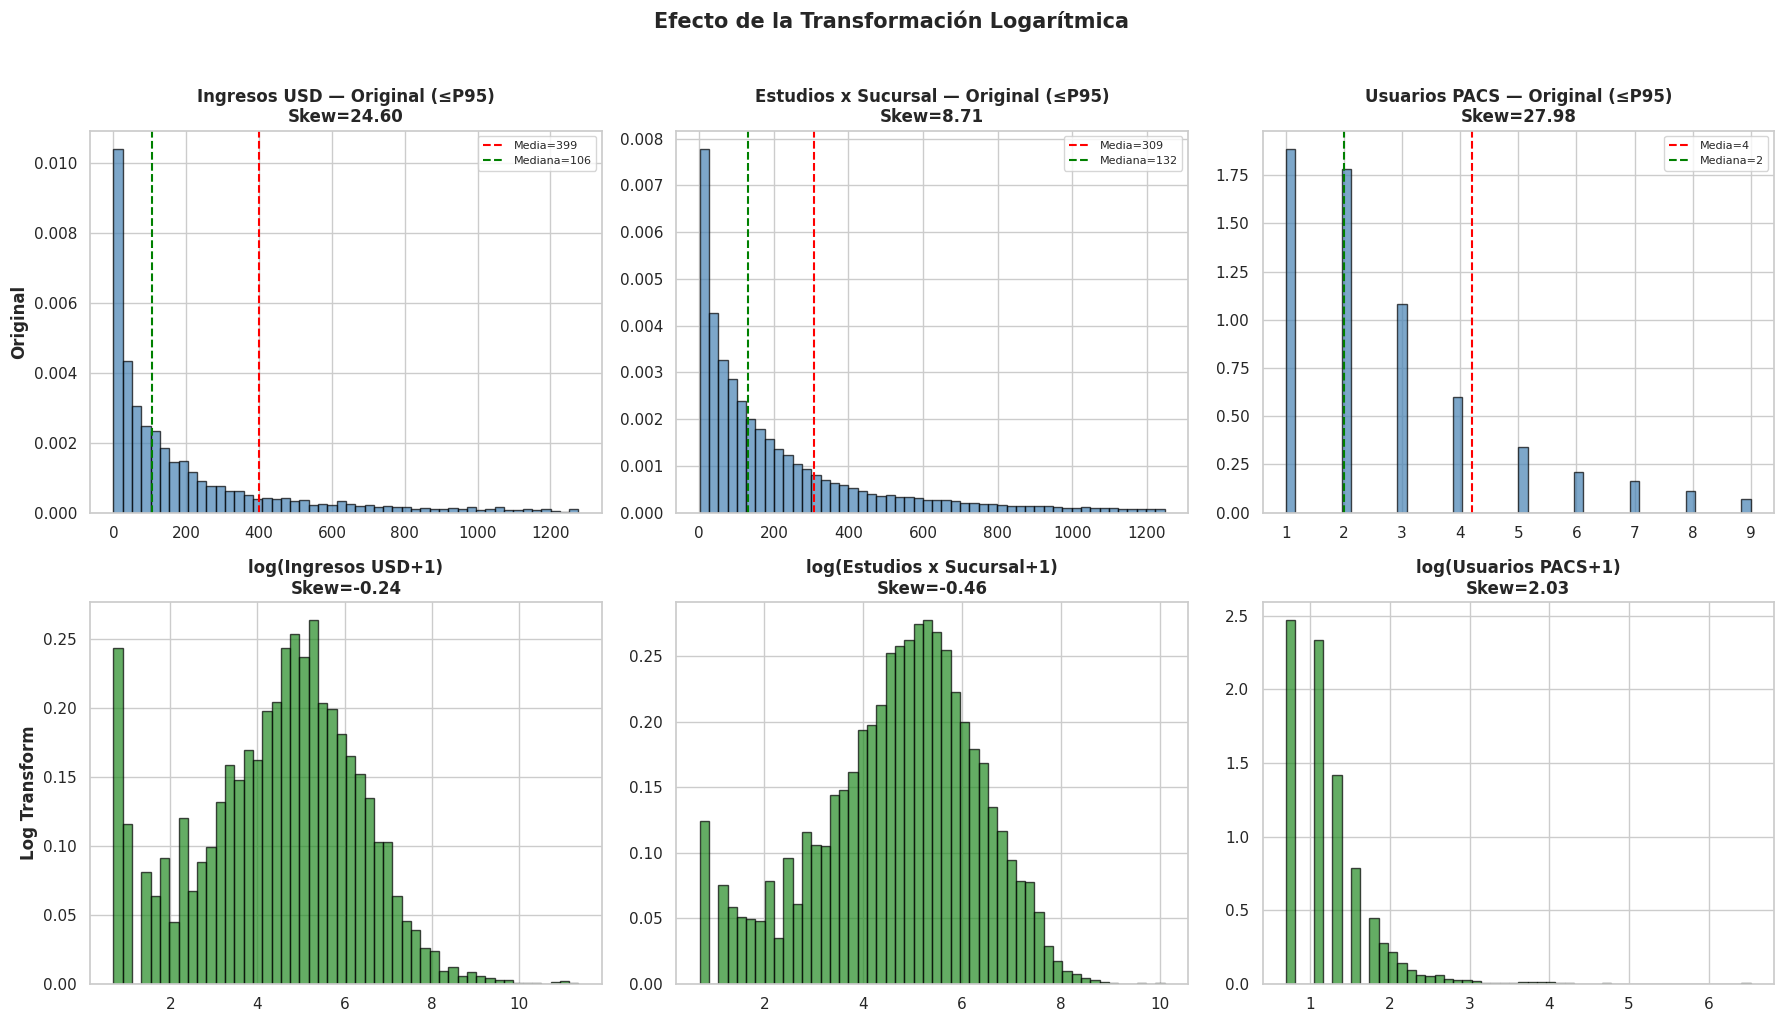

In [21]:
# Comparación Original vs Log
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
plot_vars = [('Ingresos USD', df_ingresos[COL_ING]),
             ('Estudios x Sucursal', df_sucursal['study_count']),
             ('Usuarios PACS', df_usuarios['active_doctors_count'])]

for i, (nombre, serie) in enumerate(plot_vars):
    ax = axes[0, i]
    p95 = serie.quantile(.95)
    ax.hist(serie[serie <= p95], bins=50, color='steelblue', edgecolor='black', alpha=.7, density=True)
    ax.axvline(serie.mean(), color='red', ls='--', lw=1.5, label=f'Media={serie.mean():.0f}')
    ax.axvline(serie.median(), color='green', ls='--', lw=1.5, label=f'Mediana={serie.median():.0f}')
    ax.set_title(f'{nombre} — Original (≤P95)\nSkew={skew(serie):.2f}', fontweight='bold')
    ax.legend(fontsize=8)

    ax = axes[1, i]
    log_s = np.log1p(serie[serie > 0])
    ax.hist(log_s, bins=50, color='forestgreen', edgecolor='black', alpha=.7, density=True)
    ax.set_title(f'log({nombre}+1)\nSkew={skew(log_s):.2f}', fontweight='bold')

axes[0, 0].set_ylabel('Original', fontweight='bold')
axes[1, 0].set_ylabel('Log Transform', fontweight='bold')
plt.suptitle('Efecto de la Transformación Logarítmica', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout(); plt.show()

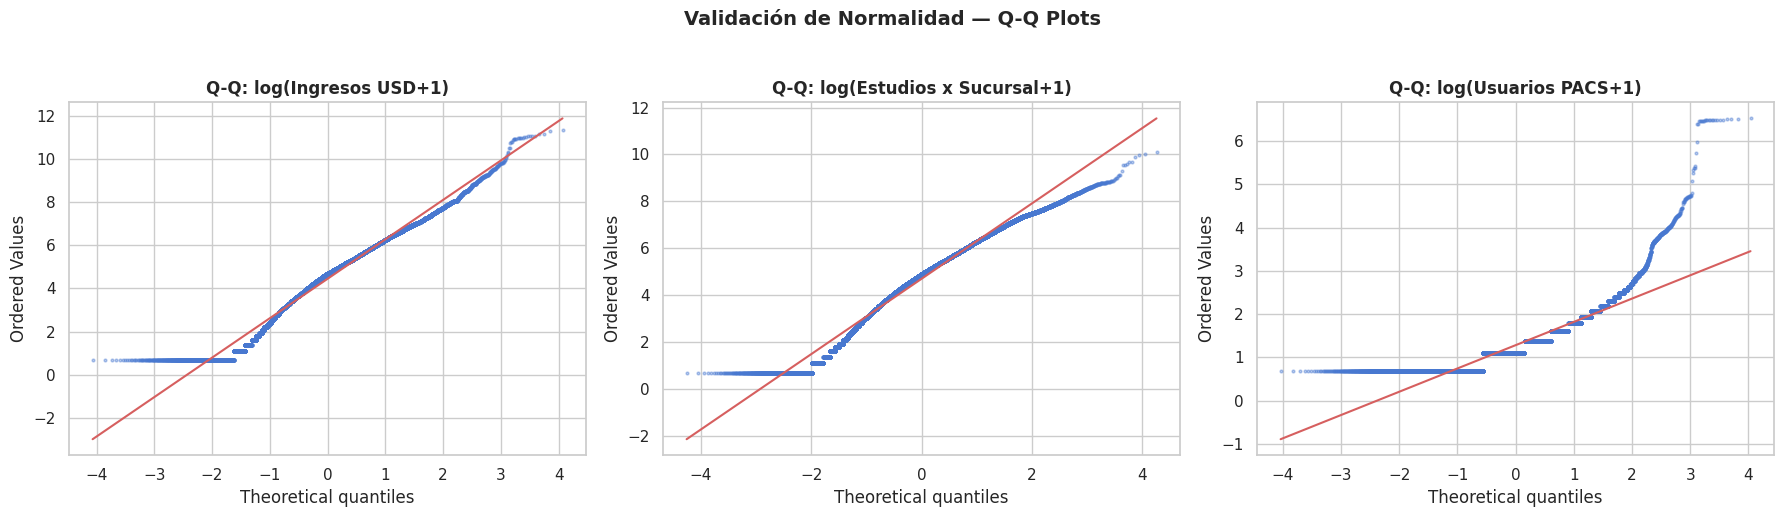

In [22]:
# Q-Q plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, (nombre, serie) in enumerate(plot_vars):
    sp_stats.probplot(np.log1p(serie[serie > 0]), dist='norm', plot=axes[i])
    axes[i].set_title(f'Q-Q: log({nombre}+1)', fontweight='bold')
    axes[i].get_lines()[0].set(markersize=2, alpha=.4)
plt.suptitle('Validación de Normalidad — Q-Q Plots', fontsize=14, fontweight='bold', y=1.03)
plt.tight_layout(); plt.show()

<a name="temporal"></a>
## 9. Tendencias Temporales

> **Pregunta EDA:** *¿Se identifican tendencias temporales?*

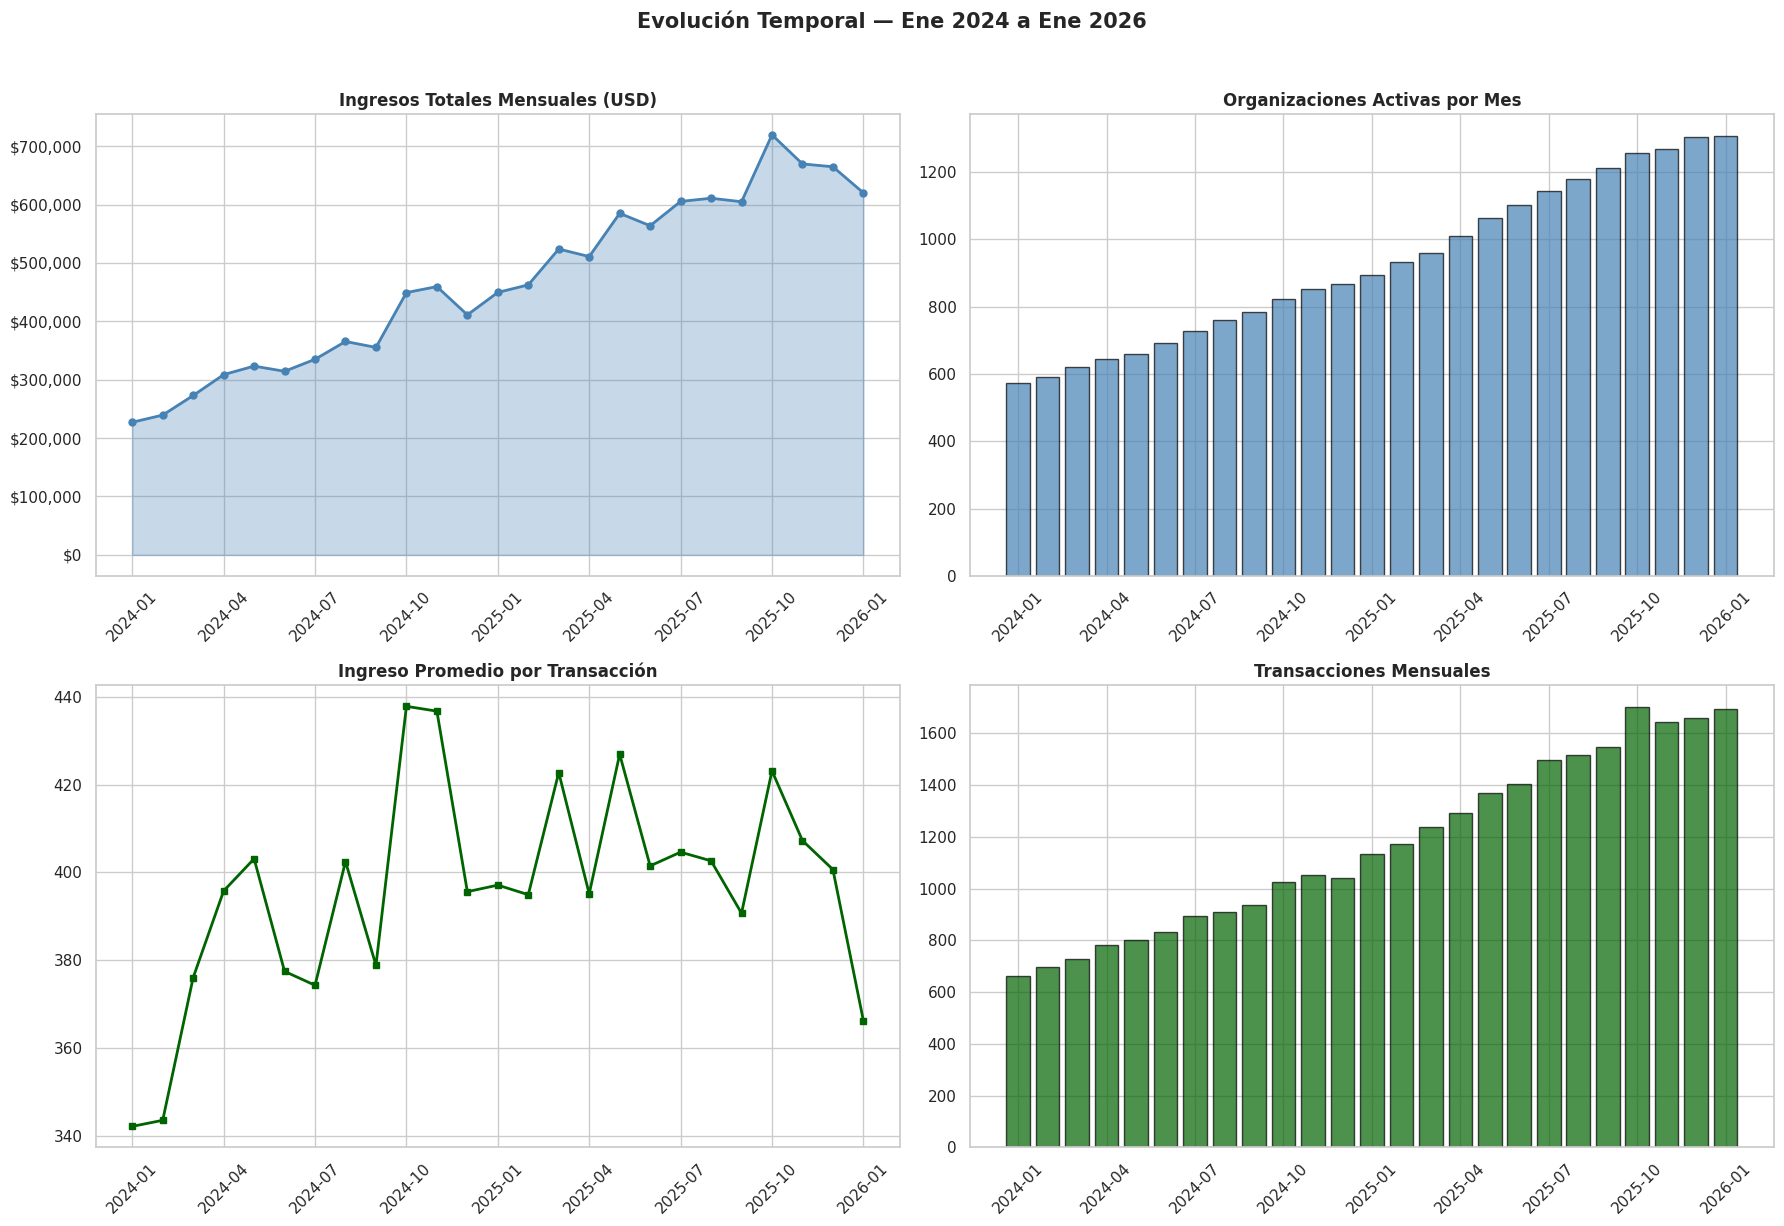

In [45]:
df_ingresos['year_month'] = pd.to_datetime(df_ingresos['ingresos_month']).dt.to_period('M')

temporal = df_ingresos.groupby('year_month').agg(
    Total_USD=(COL_ING, 'sum'), Media_USD=(COL_ING, 'mean'),
    Txns=(COL_ING, 'count'), Orgs=('name', 'nunique')
).reset_index()
temporal['label'] = temporal['year_month'].astype(str)

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
x = range(len(temporal))

ax = axes[0,0]
ax.fill_between(x, temporal['Total_USD'], alpha=.3, color='steelblue')
ax.plot(x, temporal['Total_USD'], 'o-', color='steelblue', lw=2, ms=5)
ax.set_title('Ingresos Totales Mensuales (USD)', fontweight='bold')
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda v,_: f'${v:,.0f}'))

ax = axes[0,1]
ax.bar(x, temporal['Orgs'], color='steelblue', edgecolor='black', alpha=.7)
ax.set_title('Organizaciones Activas por Mes', fontweight='bold')

ax = axes[1,0]
ax.plot(x, temporal['Media_USD'], 's-', color='darkgreen', lw=2, ms=5)
ax.set_title('Ingreso Promedio por Transacción', fontweight='bold')

ax = axes[1,1]
ax.bar(x, temporal['Txns'], color='darkgreen', edgecolor='black', alpha=.7)
ax.set_title('Transacciones Mensuales', fontweight='bold')

for ax in axes.flat:
    ax.set_xticks(list(x)[::3])
    ax.set_xticklabels(temporal['label'].iloc[::3], rotation=45)

plt.suptitle('Evolución Temporal — Ene 2024 a Ene 2026', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout(); plt.show()

In [24]:
# Métricas de crecimiento
ene24, ene26 = temporal.iloc[0], temporal.iloc[-1]
crec_ing = (ene26['Total_USD'] / ene24['Total_USD'] - 1) * 100
crec_org = (ene26['Orgs'] / ene24['Orgs'] - 1) * 100
print(' CRECIMIENTO Ene-2024 → Ene-2026')
print(f'   Ingresos:       ${ene24["Total_USD"]:>12,.0f} → ${ene26["Total_USD"]:>12,.0f}  ({crec_ing:+.1f}%)')
print(f'   Organizaciones: {ene24["Orgs"]:>12,.0f} → {ene26["Orgs"]:>12,.0f}  ({crec_org:+.1f}%)')

📈 CRECIMIENTO Ene-2024 → Ene-2026
   Ingresos:       $     227,147 → $     619,973  (+172.9%)
   Organizaciones:          572 →        1,307  (+128.5%)


### 9.1 Adopción de funcionalidades AI



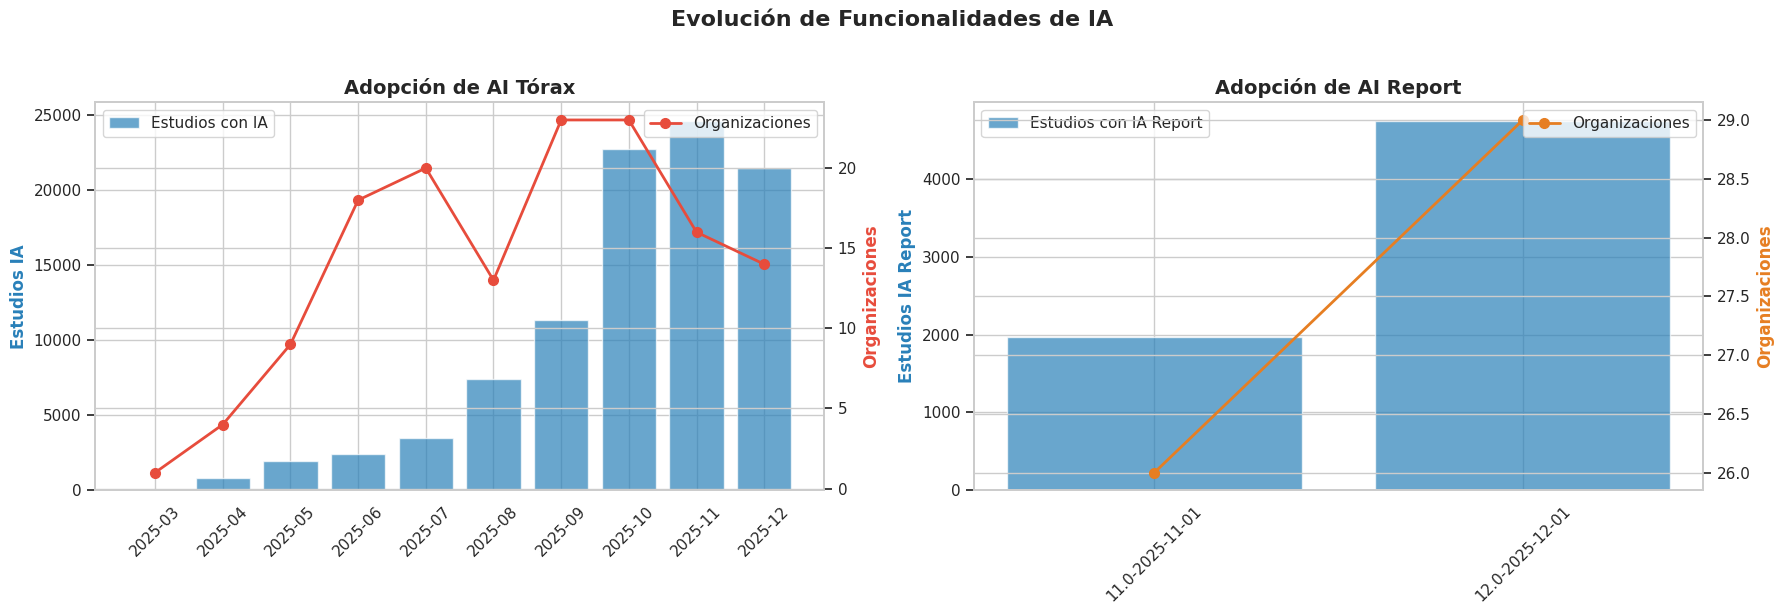

 AI Tórax  → Orgs: 50 | Estudios: 96,164
 AI Report → Orgs: 32 | Estudios: 11,388


In [46]:
col_org_ai = df_ai_torax.columns[0]
col_est_ai = 'Estudios con IA'

# ── AI Tórax: evolución temporal ──
ai_temp = df_ai_torax.groupby(['year','month']).agg(
    orgs=(col_org_ai, 'nunique'), estudios=(col_est_ai, 'sum')
).reset_index()
ai_temp['label'] = ai_temp['year'].astype(str) + '-' + ai_temp['month'].astype(str).str.zfill(2)

# ── AI Report: evolución temporal ──
rep_temp = df_ai_report.groupby(['year','month']).agg(
    orgs=('organization', 'nunique'), estudios=('study_count', 'sum')
).reset_index()
rep_temp['label'] = rep_temp['year'].astype(str) + '-' + rep_temp['month'].astype(str).str.zfill(2)

# ── Gráficos lado a lado ──
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# 1. AI Tórax
ax1 = axes[0]
x1 = range(len(ai_temp))
ax1.bar(x1, ai_temp['estudios'], color='#2980b9', alpha=.7, label='Estudios con IA')
ax1.set_ylabel('Estudios IA', color='#2980b9', fontweight='bold')
ax1b = ax1.twinx()
ax1b.plot(x1, ai_temp['orgs'], 'o-', color='#e74c3c', lw=2, ms=7, label='Organizaciones')
ax1b.set_ylabel('Organizaciones', color='#e74c3c', fontweight='bold')
ax1.set_xticks(x1)
ax1.set_xticklabels(ai_temp['label'], rotation=45)
ax1.set_title('Adopción de AI Tórax', fontsize=14, fontweight='bold')
ax1.legend(loc='upper left'); ax1b.legend(loc='upper right')

# 2. AI Report
ax2 = axes[1]
x2 = range(len(rep_temp))
ax2.bar(x2, rep_temp['estudios'], color='#2980b9', alpha=.7, label='Estudios con IA Report')
ax2.set_ylabel('Estudios IA Report', color='#2980b9', fontweight='bold')
ax2b = ax2.twinx()
ax2b.plot(x2, rep_temp['orgs'], 'o-', color='#e67e22', lw=2, ms=7, label='Organizaciones')
ax2b.set_ylabel('Organizaciones', color='#e67e22', fontweight='bold')
ax2.set_xticks(x2)
ax2.set_xticklabels(rep_temp['label'], rotation=45)
ax2.set_title('Adopción de AI Report', fontsize=14, fontweight='bold')
ax2.legend(loc='upper left'); ax2b.legend(loc='upper right')

plt.suptitle('Evolución de Funcionalidades de IA', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout(); plt.show()

# ── Resumen ──
print(f' AI Tórax  → Orgs: {df_ai_torax[col_org_ai].nunique()} | Estudios: {df_ai_torax[col_est_ai].sum():,}')
print(f' AI Report → Orgs: {df_ai_report["organization"].nunique()} | Estudios: {df_ai_report["study_count"].sum():,}')

In [26]:
print([repr(c) for c in df_ai_report.columns])

["'month'", "'organization'", "'last_recalculated_at'", "'study_count'", "'runs_count'", "'year'", "'month.1'"]


<a name="consolidar"></a>
## 10. 🔗 Consolidación del Dataset Maestro

Para los análisis de correlación y bivariado se construye un dataset a **nivel de organización** que agrega todas las fuentes.

In [27]:
# 1. Ingresos
agg1 = df_ingresos.groupby('name').agg(
    total_ingresos=(COL_ING, 'sum'),
    promedio_ingresos=(COL_ING, 'mean'),
    meses_facturado=(COL_ING, 'count')
).reset_index().rename(columns={'name': 'organization'})

# 2. Estudios / sucursales
agg2 = (df_sucursal.groupby('organization')
    .agg(total_estudios=('study_count','sum'), num_sucursales=('facility','nunique'))
    .reset_index())

# 3. Usuarios
agg3 = (df_usuarios.groupby('organization_name')
    .agg(total_usuarios=('active_doctors_count','sum'),
         prom_usuarios=('active_doctors_count','mean'))
    .reset_index()
    .rename(columns={'organization_name':'organization'}))

# 4. Envíos
agg4 = (df_envio.groupby('organization_name')
    .agg(envios_email=('studies_sent_via_email','sum'),
         envios_sms=('studies_sent_via_sms','sum'))
    .reset_index()
    .rename(columns={'organization_name':'organization'}))

# 5. PACS
agg5 = (df_pacs.groupby('organization')
    .agg(firmados=('signed','sum'), entregados=('delivered','sum'), total_pacs=('total','sum'))
    .reset_index())

# 6. Modalidades
agg6 = (df_modalidad.groupby('organization')
    .agg(num_modalidades=('modalities','nunique'), estudios_mod=('study_count','sum'))
    .reset_index())

# 7. Potencial (CRM)
agg7 = (df_potencial[['Cuenta','Potencial Mes (contrato)','País']]
    .dropna(subset=['Potencial Mes (contrato)'])
    .rename(columns={'Cuenta':'organization','Potencial Mes (contrato)':'potencial_mensual','País':'pais'}))

# MERGE
df_master = agg1
for a in [agg2, agg3, agg4, agg5, agg6, agg7]:
    df_master = df_master.merge(a, on='organization', how='left')

print(f' Dataset Maestro: {df_master.shape[0]:,} orgs × {df_master.shape[1]} vars')
display(df_master.head())

✅ Dataset Maestro: 1,476 orgs × 17 vars


,organization,total_ingresos,promedio_ingresos,meses_facturado,total_estudios,num_sucursales,total_usuarios,prom_usuarios,envios_email,envios_sms,firmados,entregados,total_pacs,num_modalidades,estudios_mod,potencial_mensual,pais
0,(CI3M) Centro Nacional de Investigación en Ima...,2357,98.208333,24,4151.0,2.0,68.0,1.888889,3507.0,3579.0,874.0,2416.0,3640.0,4.0,3639.0,50.0,Mexico
1,(DELETED) Laboratorios clínicos y especialidad...,1080,1080.000000,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,Mexico
2,3Dental,405,33.750000,12,162.0,1.0,NaN,NaN,82.0,166.0,0.0,0.0,169.0,2.0,162.0,25.0,Honduras
3,A.M.E Analisis Médicos Empresariales,193,6.892857,28,378.0,1.0,43.0,2.150000,0.0,1.0,238.0,1.0,327.0,4.0,326.0,16.0,Mexico
4,ACACIAS MEDICAL CENTER,2,1.000000,2,2.0,1.0,NaN,NaN,0.0,1.0,0.0,0.0,2.0,2.0,2.0,650.0,Mexico


<a name="correlacion"></a>
## 11. 🔗 Análisis de Correlación

> **Pregunta EDA:** *¿Hay correlación entre variables dependientes e independientes?*

In [28]:
num_cols = ['total_ingresos','total_estudios','num_sucursales','total_usuarios',
            'prom_usuarios','envios_email','envios_sms','firmados',
            'entregados','total_pacs','num_modalidades','potencial_mensual','meses_facturado']

corr_rows = []
for var in num_cols:
    if var == 'total_ingresos': continue
    clean = df_master[['total_ingresos', var]].dropna()
    if len(clean) > 10:
        rp, pp = sp_stats.pearsonr(clean['total_ingresos'], clean[var])
        rs, ps = sp_stats.spearmanr(clean['total_ingresos'], clean[var])
        fuerza = 'Muy Fuerte' if abs(rp)>.8 else ('Fuerte' if abs(rp)>.5 else ('Moderada' if abs(rp)>.3 else 'Débil'))
        corr_rows.append({'Variable': var, 'Pearson_r': round(rp,4),
                          'Spearman_ρ': round(rs,4), 'Fuerza': fuerza})

df_corr = pd.DataFrame(corr_rows).sort_values('Pearson_r', ascending=False)
display(df_corr.style.background_gradient(subset=['Pearson_r','Spearman_ρ'], cmap='RdYlGn'))

,Variable,Pearson_r,Spearman_ρ,Fuerza
8,total_pacs,0.978400,0.916300,Muy Fuerte
0,total_estudios,0.976600,0.912100,Muy Fuerte
2,total_usuarios,0.945700,0.634900,Muy Fuerte
6,firmados,0.939900,0.640100,Muy Fuerte
1,num_sucursales,0.902200,0.396600,Muy Fuerte
3,prom_usuarios,0.896300,0.547100,Muy Fuerte
9,num_modalidades,0.477300,0.702200,Moderada
5,envios_sms,0.377800,0.786200,Moderada
7,entregados,0.287700,0.609300,Débil
4,envios_email,0.275700,0.610300,Débil


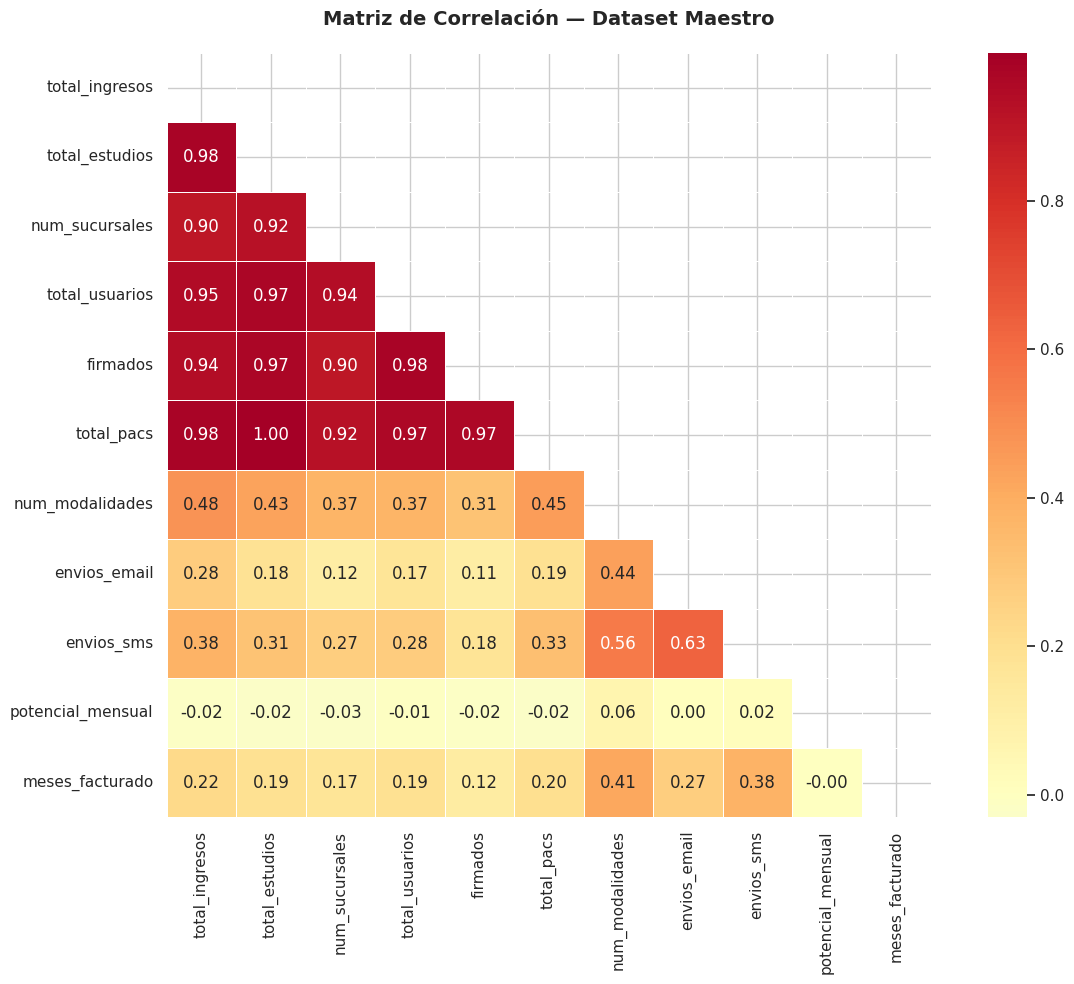

In [29]:
# Heatmap de correlación
cols_hm = ['total_ingresos','total_estudios','num_sucursales','total_usuarios',
           'firmados','total_pacs','num_modalidades','envios_email','envios_sms',
           'potencial_mensual','meses_facturado']

corr_mat = df_master[cols_hm].corr()
mask = np.triu(np.ones_like(corr_mat, dtype=bool))

fig, ax = plt.subplots(figsize=(13, 10))
sns.heatmap(corr_mat, mask=mask, annot=True, fmt='.2f', cmap='RdYlBu_r',
            center=0, square=True, linewidths=.5, ax=ax)
ax.set_title('Matriz de Correlación — Dataset Maestro', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout(); plt.show()

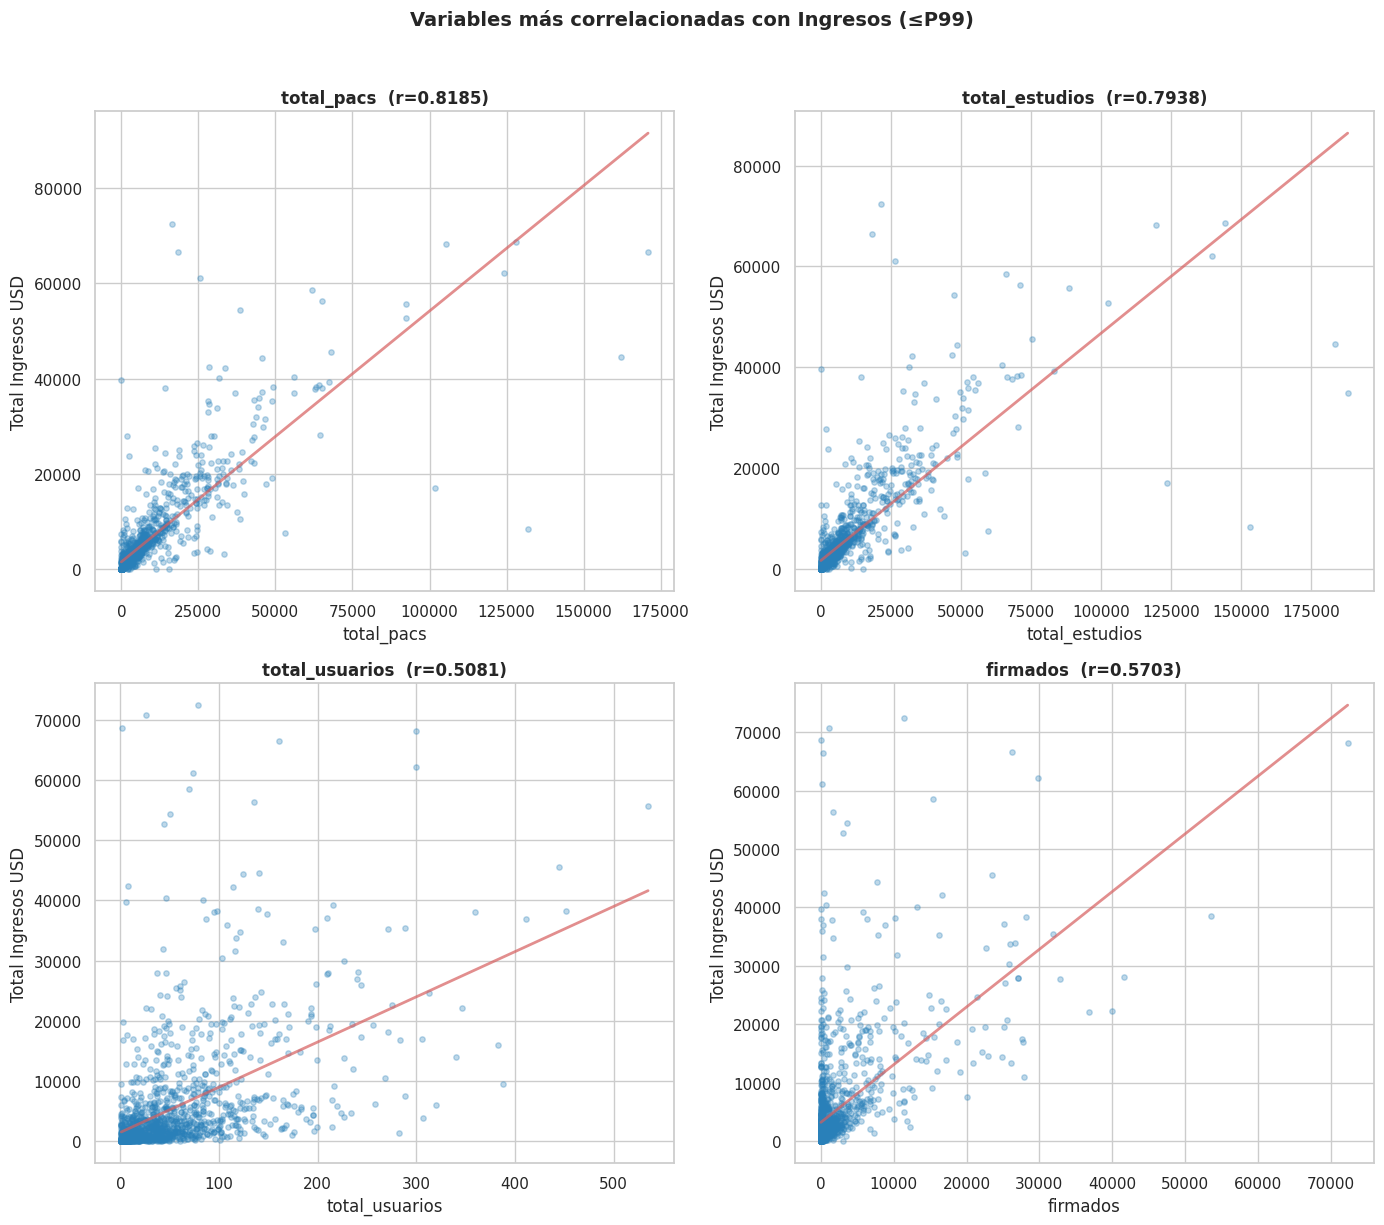

In [30]:
# Scatter plots Top 4 correlaciones
top4 = df_corr.head(4)['Variable'].tolist()

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
for i, var in enumerate(top4):
    ax = axes[i//2, i%2]
    d = df_master[['total_ingresos', var]].dropna()
    d = d[(d[var] <= d[var].quantile(.99)) & (d['total_ingresos'] <= d['total_ingresos'].quantile(.99))]
    ax.scatter(d[var], d['total_ingresos'], alpha=.3, s=15, color='#2980b9')
    z = np.polyfit(d[var], d['total_ingresos'], 1)
    xl = np.linspace(d[var].min(), d[var].max(), 100)
    ax.plot(xl, np.poly1d(z)(xl), 'r-', lw=2, alpha=.7)
    r = d[['total_ingresos', var]].corr().iloc[0,1]
    ax.set_title(f'{var}  (r={r:.4f})', fontweight='bold')
    ax.set_xlabel(var); ax.set_ylabel('Total Ingresos USD')

plt.suptitle('Variables más correlacionadas con Ingresos (≤P99)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout(); plt.show()

<a name="bivariado"></a>
## 12. Análisis Bivariado y Multivariado

> **Pregunta EDA:** *¿Cómo se distribuyen los datos en función de diferentes categorías?*

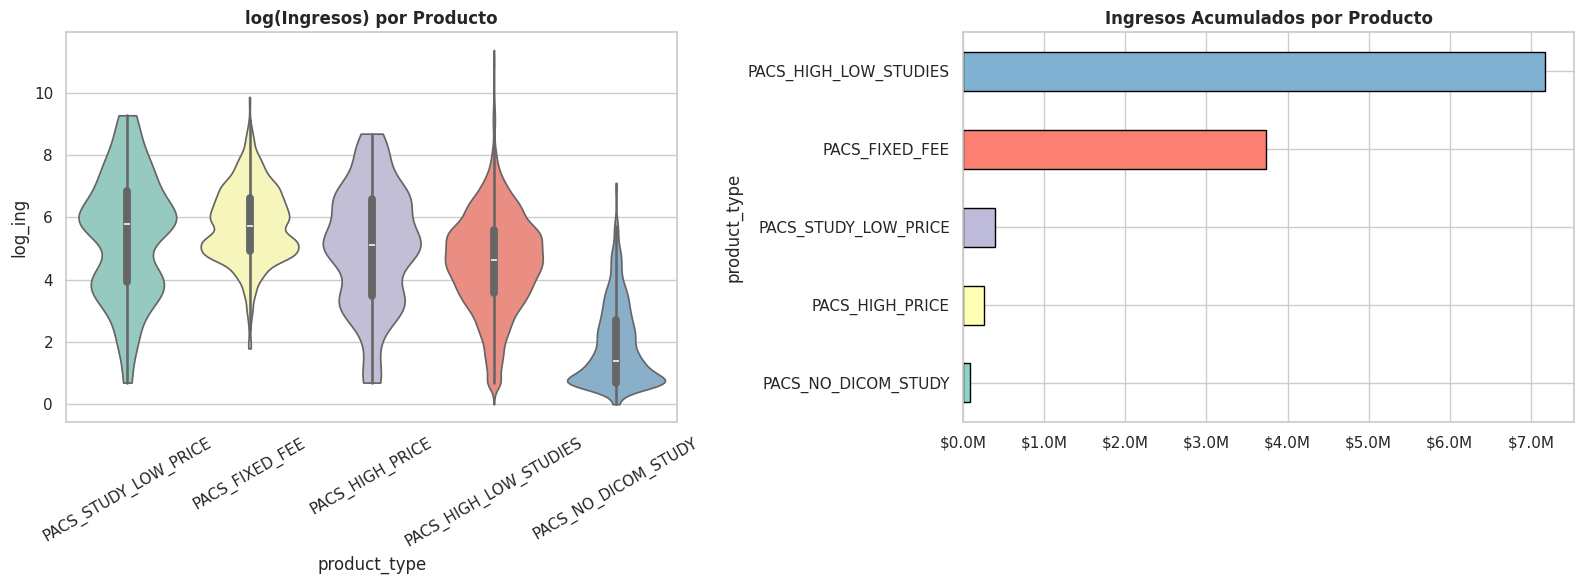

In [48]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Violin plot por producto
ax = axes[0]
tmp = df_ingresos.copy()
tmp['log_ing'] = np.log1p(tmp[COL_ING])
order = tmp.groupby('product_type')['log_ing'].median().sort_values(ascending=False).index
sns.violinplot(data=tmp, x='product_type', y='log_ing', order=order, ax=ax, palette='Set3', cut=0)
ax.set_title('log(Ingresos) por Producto', fontweight='bold')
ax.tick_params(axis='x', rotation=30)

# Ingresos acumulados por producto
ax = axes[1]
df_ingresos.groupby('product_type')[COL_ING].sum().sort_values().plot.barh(
    ax=ax, color=sns.color_palette('Set3', 5), edgecolor='black')
ax.set_title('Ingresos Acumulados por Producto', fontweight='bold')
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda v,_: f'${v/1e6:.1f}M'))

plt.tight_layout(); plt.show()

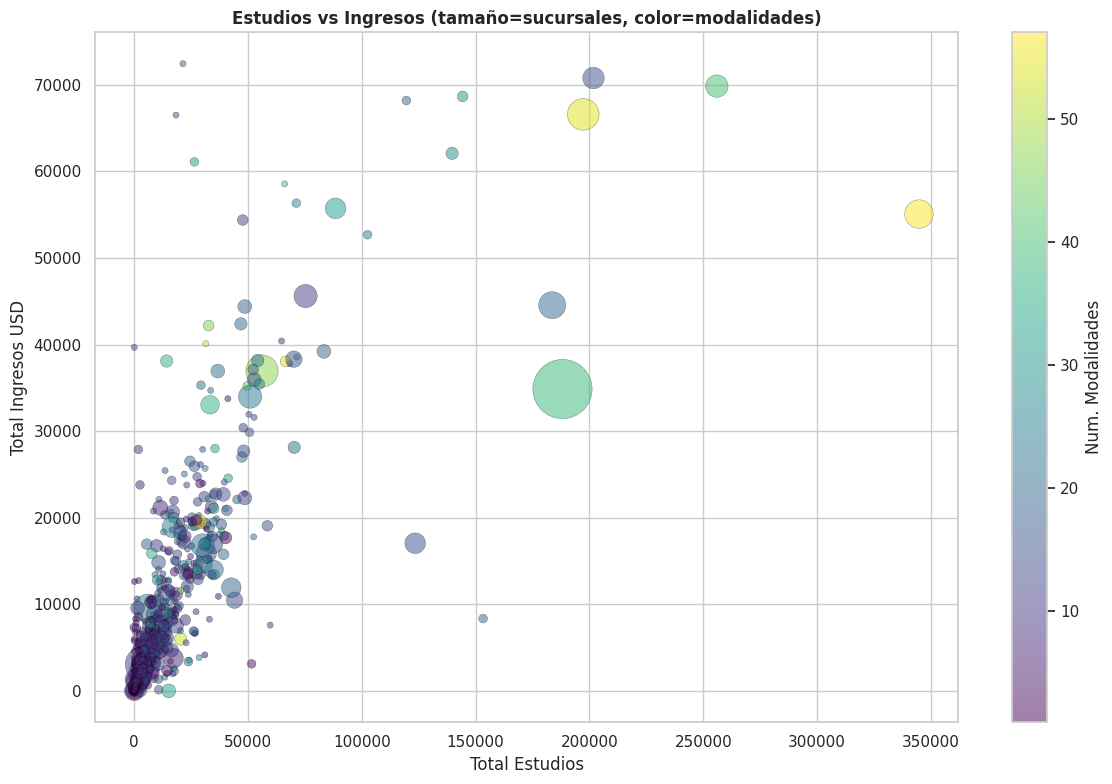

In [32]:
# Bubble chart multivariado
fig, ax = plt.subplots(figsize=(12, 8))
d = df_master.dropna(subset=['total_estudios','total_ingresos','num_sucursales','num_modalidades'])
d = d[d['total_ingresos'] <= d['total_ingresos'].quantile(.99)]

sc = ax.scatter(d['total_estudios'], d['total_ingresos'],
                s=d['num_sucursales']*20, c=d['num_modalidades'],
                cmap='viridis', alpha=.5, edgecolors='black', linewidths=.3)
plt.colorbar(sc, ax=ax, label='Num. Modalidades')
ax.set_xlabel('Total Estudios'); ax.set_ylabel('Total Ingresos USD')
ax.set_title('Estudios vs Ingresos (tamaño=sucursales, color=modalidades)', fontweight='bold')
plt.tight_layout(); plt.show()

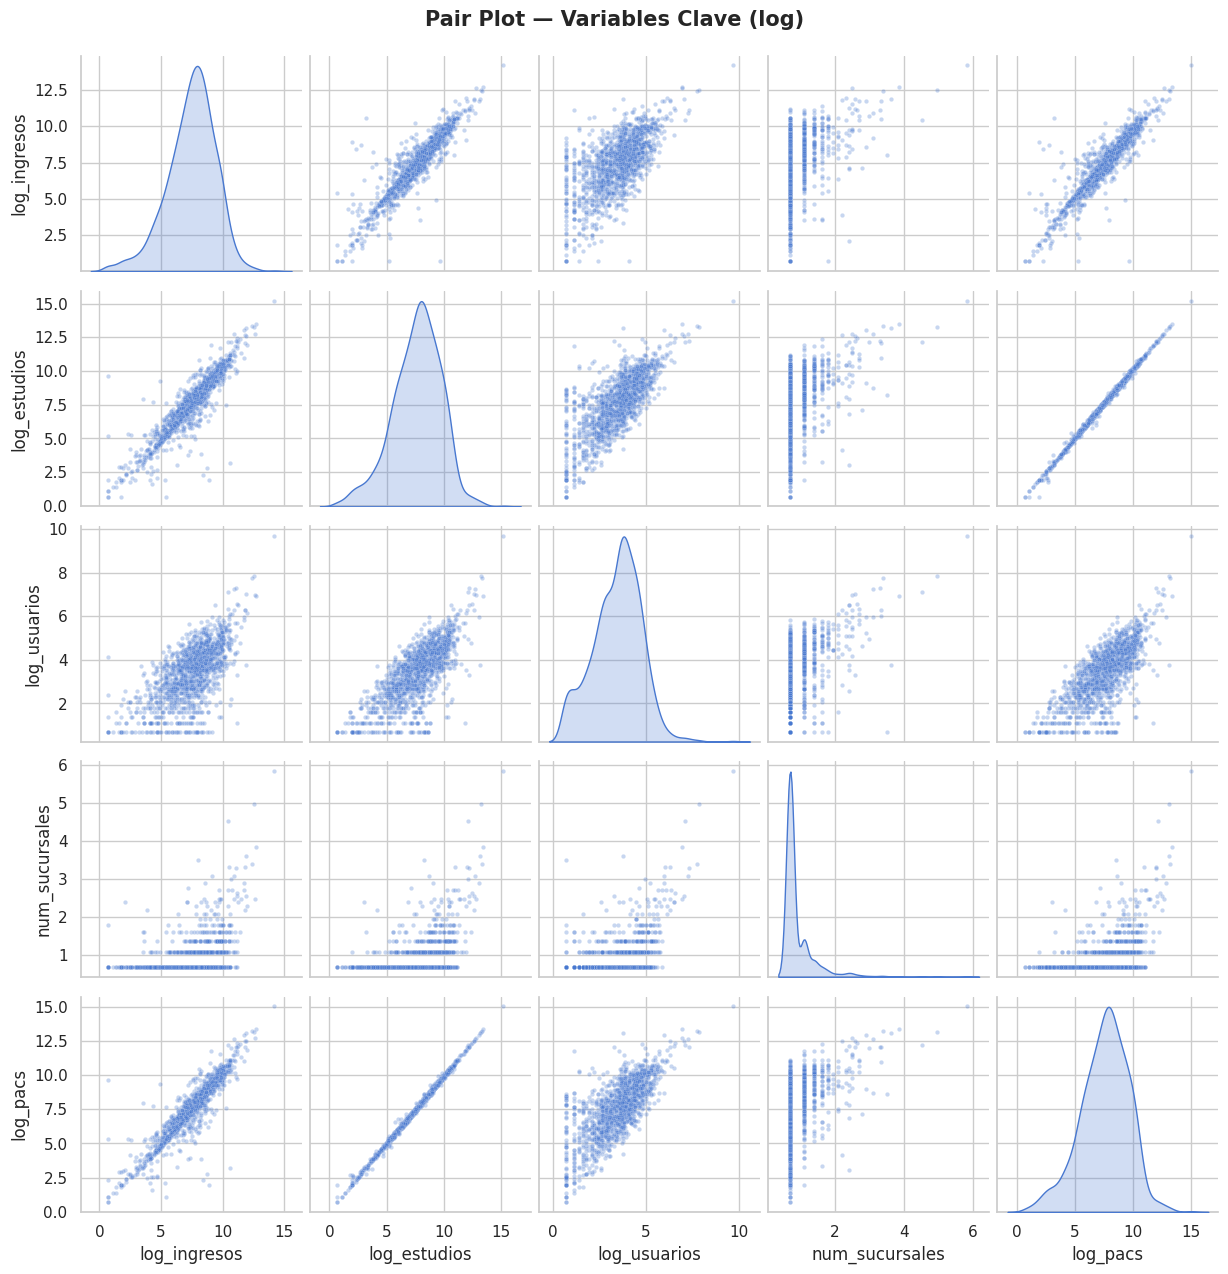

In [33]:
# Pair plot
vp = ['total_ingresos','total_estudios','total_usuarios','num_sucursales','total_pacs']
dp = np.log1p(df_master[vp].dropna())
dp.columns = [c.replace('total_','log_') for c in dp.columns]
g = sns.pairplot(dp, diag_kind='kde', plot_kws={'alpha':.3,'s':10}, diag_kws={'fill':True})
g.figure.suptitle('Pair Plot — Variables Clave (log)', fontsize=15, fontweight='bold', y=1.02)
plt.show()

<a name="desequilibrio"></a>
## 13. Desequilibrio en la Variable Objetivo

> **Pregunta EDA:** *¿Hay desequilibrio en las clases de la variable objetivo?*

Al ser una variable continua, analizamos la **concentración de ingresos** y creamos segmentos.

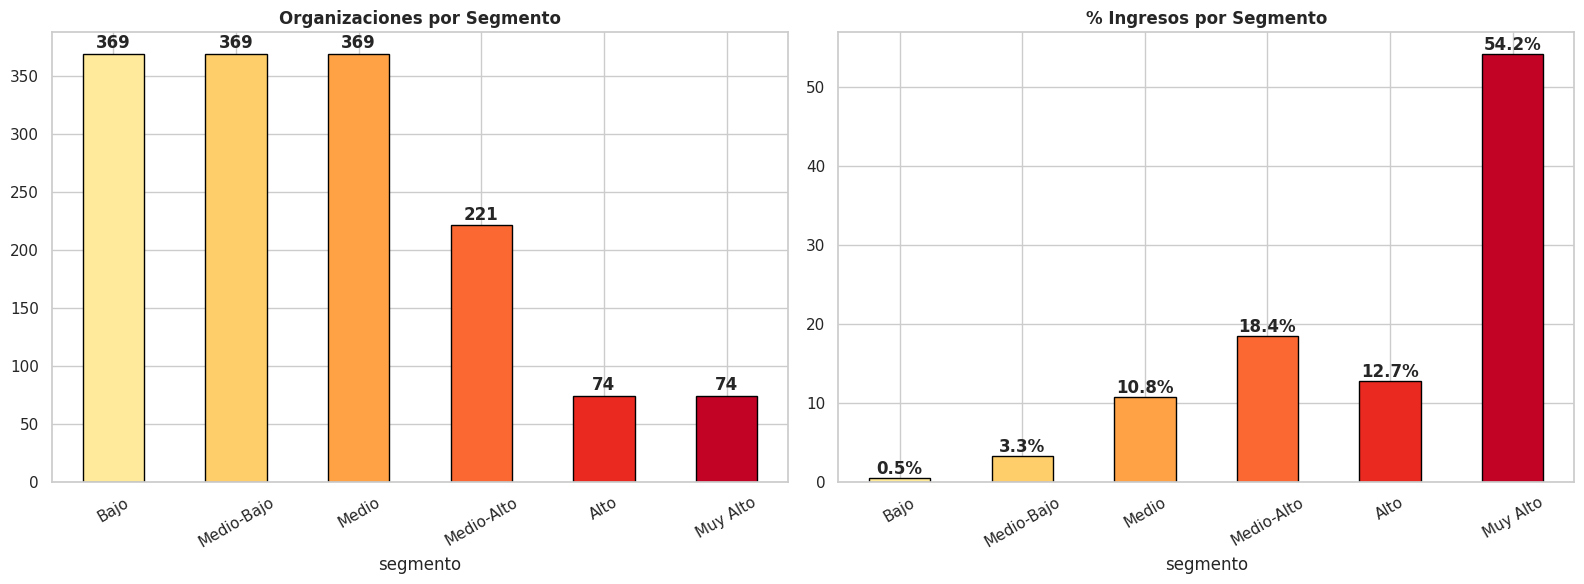

In [34]:
labels = ['Bajo','Medio-Bajo','Medio','Medio-Alto','Alto','Muy Alto']
df_master['segmento'] = pd.qcut(df_master['total_ingresos'], q=[0,.25,.5,.75,.9,.95,1], labels=labels)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Organizaciones por segmento
ax = axes[0]
seg_n = df_master['segmento'].value_counts().sort_index()
seg_n.plot.bar(ax=ax, color=sns.color_palette('YlOrRd', 6), edgecolor='black')
ax.set_title('Organizaciones por Segmento', fontweight='bold')
ax.tick_params(axis='x', rotation=30)
for i, v in enumerate(seg_n): ax.text(i, v+5, str(v), ha='center', fontweight='bold')

# % de ingresos por segmento
ax = axes[1]
seg_pct = (df_master.groupby('segmento')['total_ingresos'].sum() /
           df_master['total_ingresos'].sum() * 100)
seg_pct.plot.bar(ax=ax, color=sns.color_palette('YlOrRd', 6), edgecolor='black')
ax.set_title('% Ingresos por Segmento', fontweight='bold')
ax.tick_params(axis='x', rotation=30)
for i, v in enumerate(seg_pct): ax.text(i, v+.5, f'{v:.1f}%', ha='center', fontweight='bold')

plt.tight_layout(); plt.show()

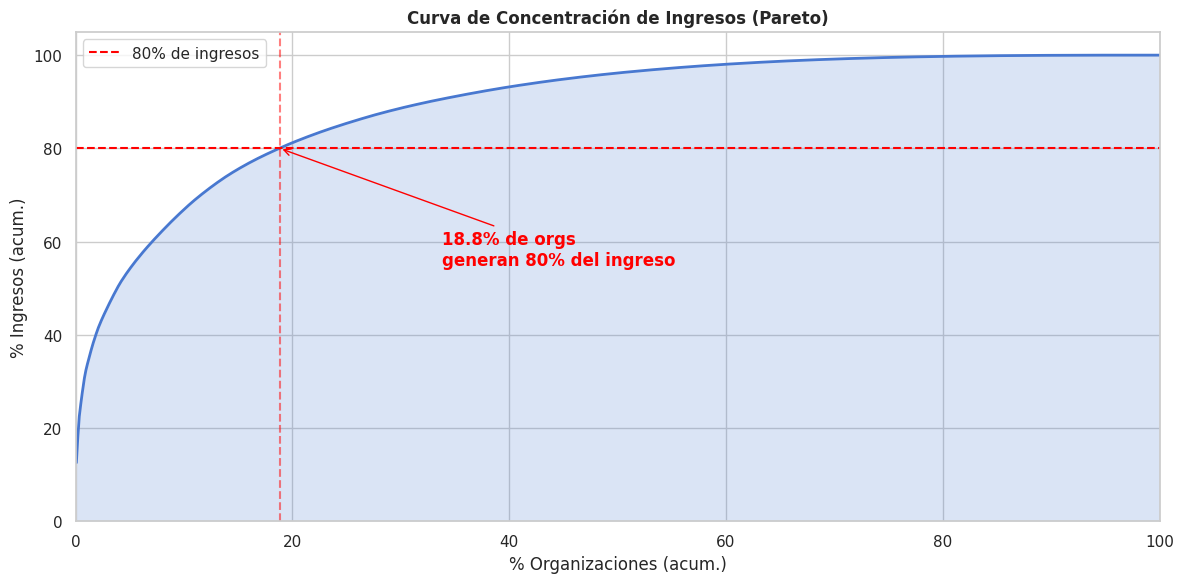

📌 18.8% de las organizaciones generan el 80% de los ingresos


In [35]:
# Curva de Pareto
ds = df_master.sort_values('total_ingresos', ascending=False).reset_index(drop=True)
ds['pct_acum'] = ds['total_ingresos'].cumsum() / ds['total_ingresos'].sum() * 100
ds['pct_orgs'] = (ds.index + 1) / len(ds) * 100

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(ds['pct_orgs'], ds['pct_acum'], 'b-', lw=2)
ax.fill_between(ds['pct_orgs'], ds['pct_acum'], alpha=.2)
ax.axhline(80, color='red', ls='--', label='80% de ingresos')

idx80 = (ds['pct_acum'] >= 80).idxmax()
p80 = ds.loc[idx80, 'pct_orgs']
ax.axvline(p80, color='red', ls='--', alpha=.5)
ax.annotate(f'{p80:.1f}% de orgs\ngeneran 80% del ingreso',
            xy=(p80, 80), xytext=(p80+15, 55),
            arrowprops=dict(arrowstyle='->', color='red'),
            fontsize=12, fontweight='bold', color='red')

ax.set_xlabel('% Organizaciones (acum.)')
ax.set_ylabel('% Ingresos (acum.)')
ax.set_title('Curva de Concentración de Ingresos (Pareto)', fontweight='bold')
ax.legend(); ax.set_xlim(0,100); ax.set_ylim(0,105)
plt.tight_layout(); plt.show()
print(f' {p80:.1f}% de las organizaciones generan el 80% de los ingresos')

<a name="preprocesamiento"></a>
## 14. 🛠️ Preprocesamiento Aplicado y Justificado

### 14.1 Tratamiento de valores faltantes

In [36]:
df_clean = df_master.copy()
print('ANTES:', df_clean.isnull().sum()[df_clean.isnull().sum() > 0].to_dict())

# Variables de producto → 0 (no-uso)
cols_prod = ['total_estudios','num_sucursales','total_usuarios','prom_usuarios',
             'envios_email','envios_sms','firmados','entregados','total_pacs',
             'num_modalidades','estudios_mod']
df_clean[cols_prod] = df_clean[cols_prod].fillna(0)

# Potencial → mediana
med = df_clean['potencial_mensual'].median()
df_clean['potencial_mensual'] = df_clean['potencial_mensual'].fillna(med)

# País → 'Desconocido'
df_clean['pais'] = df_clean['pais'].fillna('Desconocido')

print('DESPUÉS:', df_clean.isnull().sum().sum(), 'faltantes')

ANTES: {'total_estudios': 5, 'num_sucursales': 5, 'total_usuarios': 136, 'prom_usuarios': 136, 'envios_email': 67, 'envios_sms': 67, 'firmados': 5, 'entregados': 5, 'total_pacs': 5, 'num_modalidades': 5, 'estudios_mod': 5, 'potencial_mensual': 79, 'pais': 114}
DESPUÉS: 0 faltantes


### 14.2 Tratamiento de outliers — Winsorización al P99

In [37]:
cols_w = ['total_ingresos','total_estudios','total_usuarios','envios_email',
          'envios_sms','firmados','entregados','total_pacs','estudios_mod']

print('Winsorización al P99:')
for col in cols_w:
    p99 = df_clean[col].quantile(.99)
    n = (df_clean[col] > p99).sum()
    df_clean[f'{col}_w'] = df_clean[col].clip(upper=p99)
    print(f'  {col:<25} P99={p99:>12,.0f}  ({n} afectados)')

Winsorización al P99:
  total_ingresos            P99=      74,131  (15 afectados)
  total_estudios            P99=     188,962  (15 afectados)
  total_usuarios            P99=         532  (15 afectados)
  envios_email              P99=      28,335  (15 afectados)
  envios_sms                P99=      55,307  (15 afectados)
  firmados                  P99=      75,646  (15 afectados)
  entregados                P99=      45,578  (15 afectados)
  total_pacs                P99=     172,080  (15 afectados)
  estudios_mod              P99=     169,937  (15 afectados)


### 14.3 Transformación logarítmica

In [38]:
cols_log = ['total_ingresos','total_estudios','total_usuarios','envios_email',
            'envios_sms','firmados','total_pacs','potencial_mensual','promedio_ingresos']

print(f'{"Variable":<30} {"Skew Orig":>12} {"Skew Log":>12}')
print('─' * 56)
for col in cols_log:
    s_orig = skew(df_clean[col].dropna())
    df_clean[f'log_{col}'] = np.log1p(df_clean[col])
    s_log = skew(df_clean[f'log_{col}'].dropna())
    print(f'  {col:<28} {s_orig:>12.2f} {s_log:>12.2f}')

Variable                          Skew Orig     Skew Log
────────────────────────────────────────────────────────
  total_ingresos                      27.39        -0.76
  total_estudios                      31.12        -0.65
  total_usuarios                      33.33        -0.40
  envios_email                         9.56         0.12
  envios_sms                           8.91        -0.74
  firmados                            35.49        -0.07
  total_pacs                          30.14        -0.63
  potencial_mensual                    1.48        -0.87
  promedio_ingresos                   18.10        -0.23


### 14.4 Feature Engineering

In [39]:
# Variables derivadas de negocio
df_clean['ratio_utilizacion'] = np.where(
    df_clean['potencial_mensual'] > 0,
    df_clean['total_estudios'] / (df_clean['potencial_mensual'] * df_clean['meses_facturado']), 0)

df_clean['ingreso_por_estudio'] = np.where(
    df_clean['total_estudios'] > 0, df_clean['total_ingresos'] / df_clean['total_estudios'], 0)

df_clean['ingreso_por_usuario'] = np.where(
    df_clean['total_usuarios'] > 0, df_clean['total_ingresos'] / df_clean['total_usuarios'], 0)

df_clean['tasa_firma'] = np.where(
    df_clean['total_pacs'] > 0, df_clean['firmados'] / df_clean['total_pacs'], 0)

df_clean['estudios_por_sucursal'] = np.where(
    df_clean['num_sucursales'] > 0, df_clean['total_estudios'] / df_clean['num_sucursales'], 0)

print(' Features creadas:')
feats = ['ratio_utilizacion','ingreso_por_estudio','ingreso_por_usuario','tasa_firma','estudios_por_sucursal']
display(df_clean[feats].describe().round(2))

✅ Features creadas:


,ratio_utilizacion,ingreso_por_estudio,ingreso_por_usuario,tasa_firma,estudios_por_sucursal
count,1476.00,1476.00,1476.00,1476.00,1476.00
mean,84.36,5.99,202.55,0.28,4903.98
std,353.59,65.14,1061.76,0.32,8595.40
min,0.00,0.00,0.00,0.00,0.00
25%,0.31,0.55,15.53,0.02,363.25
50%,0.95,0.83,50.91,0.13,1706.50
75%,1.73,1.12,135.06,0.52,5363.62
max,7590.50,1725.00,34322.00,1.00,76629.00


In [40]:
print('═' * 60)
print('RESUMEN DEL DATASET PREPROCESADO')
print('═' * 60)
print(f'  Dimensiones:      {df_clean.shape[0]:,} orgs × {df_clean.shape[1]} vars')
print(f'  Faltantes:        {df_clean.isnull().sum().sum()}')
n_orig = len([c for c in df_clean.columns if not c.startswith('log_') and not c.endswith('_w')])
n_log = len([c for c in df_clean.columns if c.startswith('log_')])
n_w = len([c for c in df_clean.columns if c.endswith('_w')])
print(f'  Vars originales:  {n_orig}')
print(f'  Vars log:         {n_log}')
print(f'  Vars winsorized:  {n_w}')
print(f'  Features nuevas:  {len(feats)}')

════════════════════════════════════════════════════════════
RESUMEN DEL DATASET PREPROCESADO
════════════════════════════════════════════════════════════
  Dimensiones:      1,476 orgs × 41 vars
  Faltantes:        0
  Vars originales:  23
  Vars log:         9
  Vars winsorized:  9
  Features nuevas:  5


<a name="conclusiones"></a>
## 15. Conclusiones del EDA

---

### 15.1 Hallazgos Principales

**1. Calidad de datos diferenciada por fuente:**
- Datos del producto (PACS): <1% de faltantes — alta fiabilidad por ser generados automáticamente.
- Datos del CRM: hasta 53% de faltantes (consistente con la estandarización reciente a partir de 2025).

**2. Distribuciones altamente sesgadas:**
- Todas las variables numéricas tienen sesgo extremo positivo (skewness > 8), patrón log-normal.
- La transformación `log(x+1)` reduce el sesgo drásticamente (de 24.6 a -0.24 en ingresos).

**3. Correlación muy fuerte entre uso e ingresos — modelo de negocio validado:**
- `total_pacs` (r = 0.98), `total_estudios` (r = 0.98), `total_usuarios` (r = 0.95) y `num_sucursales` (r = 0.90) son las variables más correlacionadas.
- Confirma que el modelo de monetización basado en volumen funciona correctamente.

**4. Paradoja del potencial contractual:**
- `potencial_mensual` tiene correlación prácticamente nula (r ≈ -0.02) con los ingresos reales.
- La capacidad teórica del contrato no predice el uso real: hallazgo relevante para el equipo comercial.

**5. Alta concentración de ingresos (Pareto):**
- Un porcentaje pequeño de organizaciones genera la gran mayoría del revenue.
- PROA es un outlier significativo que representa un porcentaje desproporcionado de los ingresos totales.

**6. Crecimiento sostenido con estacionalidad:**
- Ingresos ~173% y base de clientes ~128% (Ene 2024 → Ene 2026).
- Pico de ingresos en octubre 2025.

**7. Oportunidad en funcionalidades AI:**
- Solo ~3.4% de organizaciones usan AI Tórax y ~2.2% AI Report → potencial de upselling.

---

### 15.2 Resumen del Preprocesamiento

| Operación | Justificación | Variables |
|-----------|---------------|-----------|
| Imputación con 0 | Ausencia = no-uso del feature | Variables de producto |
| Imputación con mediana | Dato faltante por CRM no estandarizado | `potencial_mensual` |
| Imputación "Desconocido" | Dato faltante del CRM | `pais` |
| Winsorización P99 | Atenuar efecto de outliers sin eliminarlos | Numéricas continuas |
| Transformación log(x+1) | Reducir sesgo extremo (>8) y aproximar a normalidad | Numéricas principales |
| Feature Engineering | Métricas de negocio interpretables | 5 variables derivadas |

---
